# Introduction

This notebook will contain an analysis of two distinct datasets, each corresponding to a different dataset type: experimental and simulated. Both datasets apply to a comparable building, highlighting the alignment between experimental and simulated scenarios. Experimental and simulation data were based on a small commercial building located in Iowa. These data covered different seasons, namely summer, winter and transitional periods, to allow a comprehensive assessment of the building's behavior under different conditions.

Dataset contains following data:

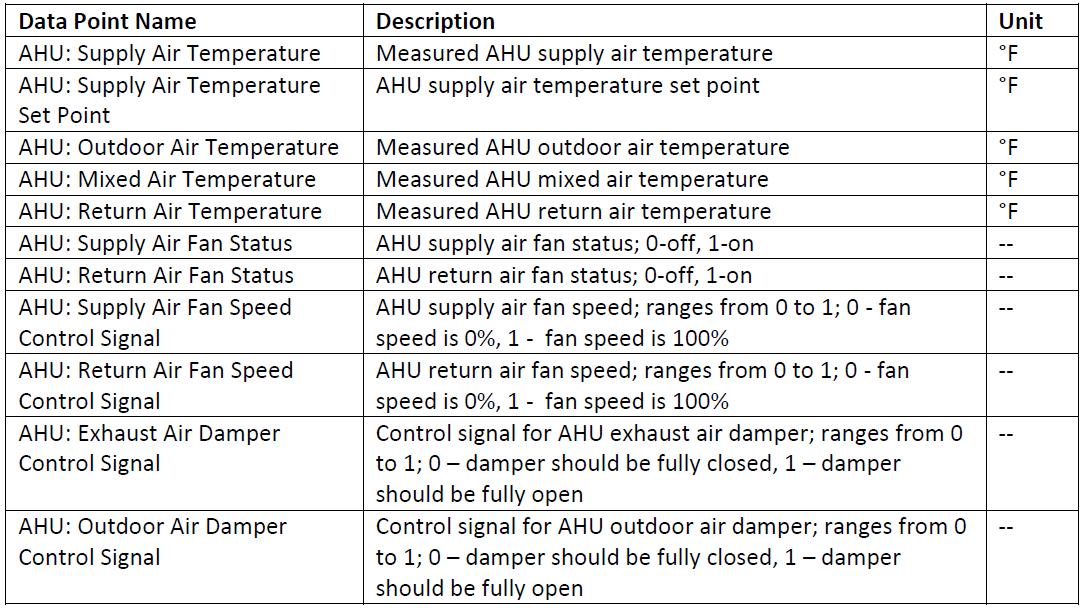
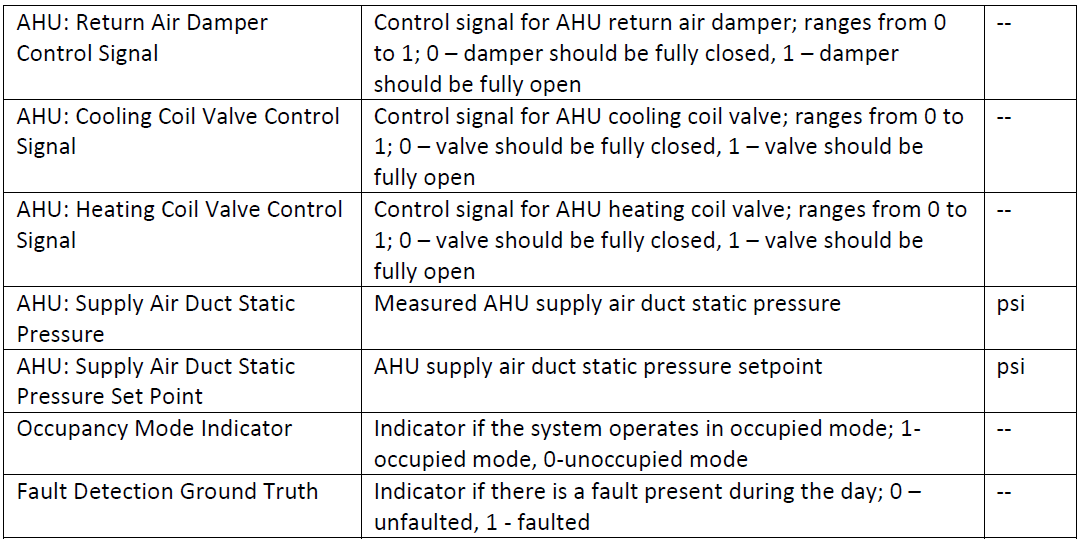

In the actual building, faults were manualy introduced into the control system for a duration of one day, as outlined in the table provided below:

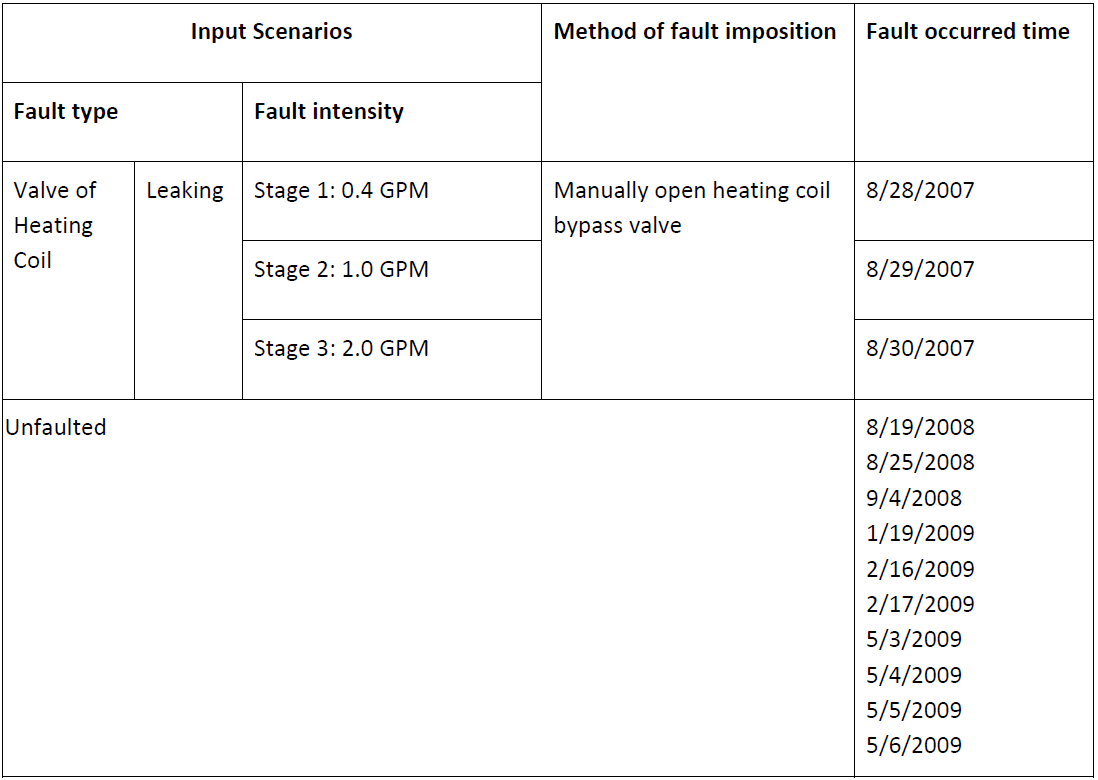

Similarly, within the simulation context, faults were manually introduced into the system for a single day, mirroring the approach delineated in the following table:

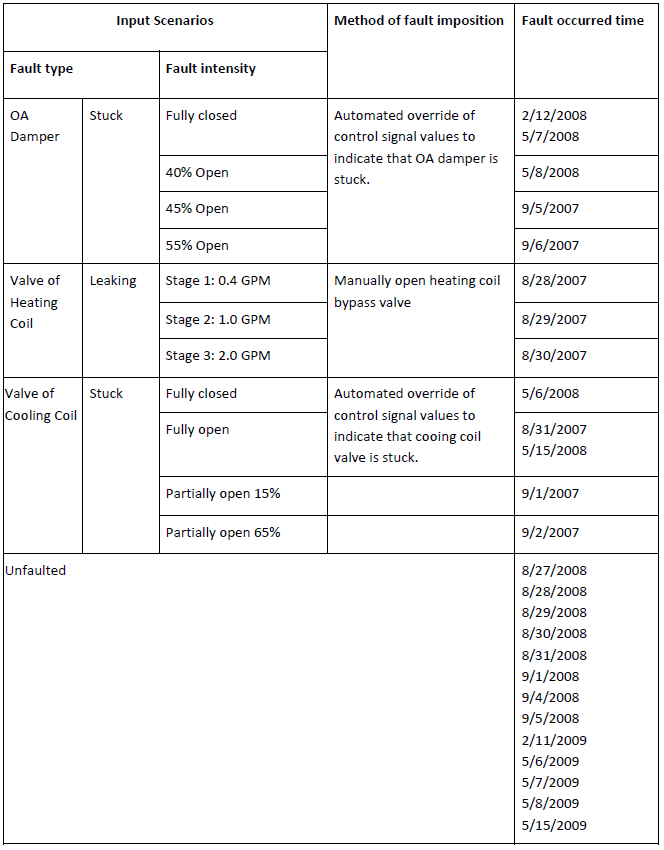

It's evident that the simulated dataset have a broader spectrum of fault types. Interestingly, there exists an overlap between faults featured in both the experimental and simulated datasets. This overlap provides a unique opportunity to put together models developed using distinct tools and check whether a model trained with simulated data can effectively generalize to real building data. This comparison promises valuable insights into the models' adaptability and performance across different scenarios.

# Import of the relevant libraries and notebook preparation

In [1]:
import sys
import os

In [2]:
src_path = os.path.join(os.getcwd(), "..", "src")
sys.path.append(src_path)

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from helper_functions import convert_date, train_evaluate_classification_models, train_evaluate_regression_models
import copy

In [4]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [5]:
# preparing list of classifiacation algorithms for comparison and to choose the best one
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [6]:
warnings.filterwarnings("ignore")

In [7]:
csv_file_path_1 = os.path.join("..", "data", "MZVAV-2-1.csv")
csv_file_path_2 = os.path.join("..", "data", "MZVAV-2-2.csv")

In [8]:
raw_data_exp = pd.read_csv(csv_file_path_1)

In [9]:
raw_data_sim = pd.read_csv(csv_file_path_2)

# Experimental dataset

## Data exploration and feature engineering

In [10]:
raw_data_exp.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
5290,8/19/2008 16:10,55.58,55,85.37,75.67,72.81,1,1,0.77,0.62,0.4,0.40,0.40,0.54,0.00,1.4,1.38,1,0
21577,5/31/2009 23:37,65.91,55,67.17,66.33,72.71,0,0,0.20,0.20,0.0,0.00,0.00,0.00,0.00,1.4,0.00,0,0
1247,8/28/2007 20:47,69.46,55,72.60,70.79,73.76,0,0,0.20,0.20,0.0,0.00,1.00,0.00,0.00,1.4,0.00,0,1
515,8/28/2007 8:35,55.58,55,78.33,75.24,74.39,1,1,0.71,0.57,0.4,0.40,0.60,0.49,0.00,1.4,1.35,1,1
9052,1/19/2009 6:52,69.89,65,25.54,46.38,71.66,1,1,0.69,0.55,1.0,0.54,0.54,0.00,0.87,1.4,1.42,1,0


In [11]:
raw_data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Datetime                                        21600 non-null  object 
 1   AHU: Supply Air Temperature                     21600 non-null  float64
 2   AHU: Supply Air Temperature Set Point           21600 non-null  int64  
 3   AHU: Outdoor Air Temperature                    21600 non-null  float64
 4   AHU: Mixed Air Temperature                      21600 non-null  float64
 5   AHU: Return Air Temperature                     21600 non-null  float64
 6   AHU: Supply Air Fan Status                      21600 non-null  int64  
 7   AHU: Return Air Fan Status                      21600 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        21600 non-null  float64
 9   AHU: Return Air Fan Speed Control Signa

The dataset is devoid of any null values and object-type columns, rendering data cleaning unnecessary in these aspects. The sole exception pertains to the "Datetime" column, which will undergo a transformation into the DateTime data format.

In [12]:
# Changing data type of the Datetime column
raw_data_exp['Datetime'] = pd.to_datetime(raw_data_exp['Datetime'])

In [13]:
raw_data_exp.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000,2.160000e+04,21600.000000,21600.000000,21600.000000
mean,62.996525,57.000463,58.220122,67.488618,72.611413,0.534722,0.533611,0.474657,0.398145,0.341757,0.331989,0.443025,0.168748,0.083330,1.400000e+00,0.738494,0.500000,0.133333
std,7.372700,4.000440,21.458405,7.875141,1.679548,0.498804,0.498881,0.261236,0.189342,0.372642,0.368341,0.400821,0.252140,0.249985,5.278122e-13,0.695622,0.500012,0.339943
min,0.000000,55.000000,-0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,0.000000,0.000000,0.000000
25%,55.150000,55.000000,44.980000,64.100000,71.340000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,0.000000,0.000000,0.000000
50%,64.840000,55.000000,63.640000,68.660000,72.810000,1.000000,1.000000,0.620000,0.500000,0.400000,0.400000,0.400000,0.000000,0.000000,1.400000e+00,1.340000,0.500000,0.000000
75%,70.430000,55.000000,74.550000,72.590000,73.440000,1.000000,1.000000,0.720000,0.570000,0.470000,0.470000,1.000000,0.290000,0.000000,1.400000e+00,1.390000,1.000000,0.000000
max,79.690000,65.000000,91.850000,108.240000,79.120000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.400000e+00,2.370000,1.000000,1.000000


Data seems to be cleaned. Now it's time to select relevant data for model building.

In [14]:
# Making copy of dataset for further data transformation
data_exp = raw_data_exp.copy()

Observing the dataset reveals that the column labeled "AHU: Supply Air Duct Static Pressure Set Point" maintains a constant value throughout. As a result, it is necessary to eliminate this column from the dataset, as it imparts negligible information for modeling purposes.

In [15]:
data_exp.drop('AHU: Supply Air Duct Static Pressure Set Point', axis=1, inplace=True)

<AxesSubplot:>

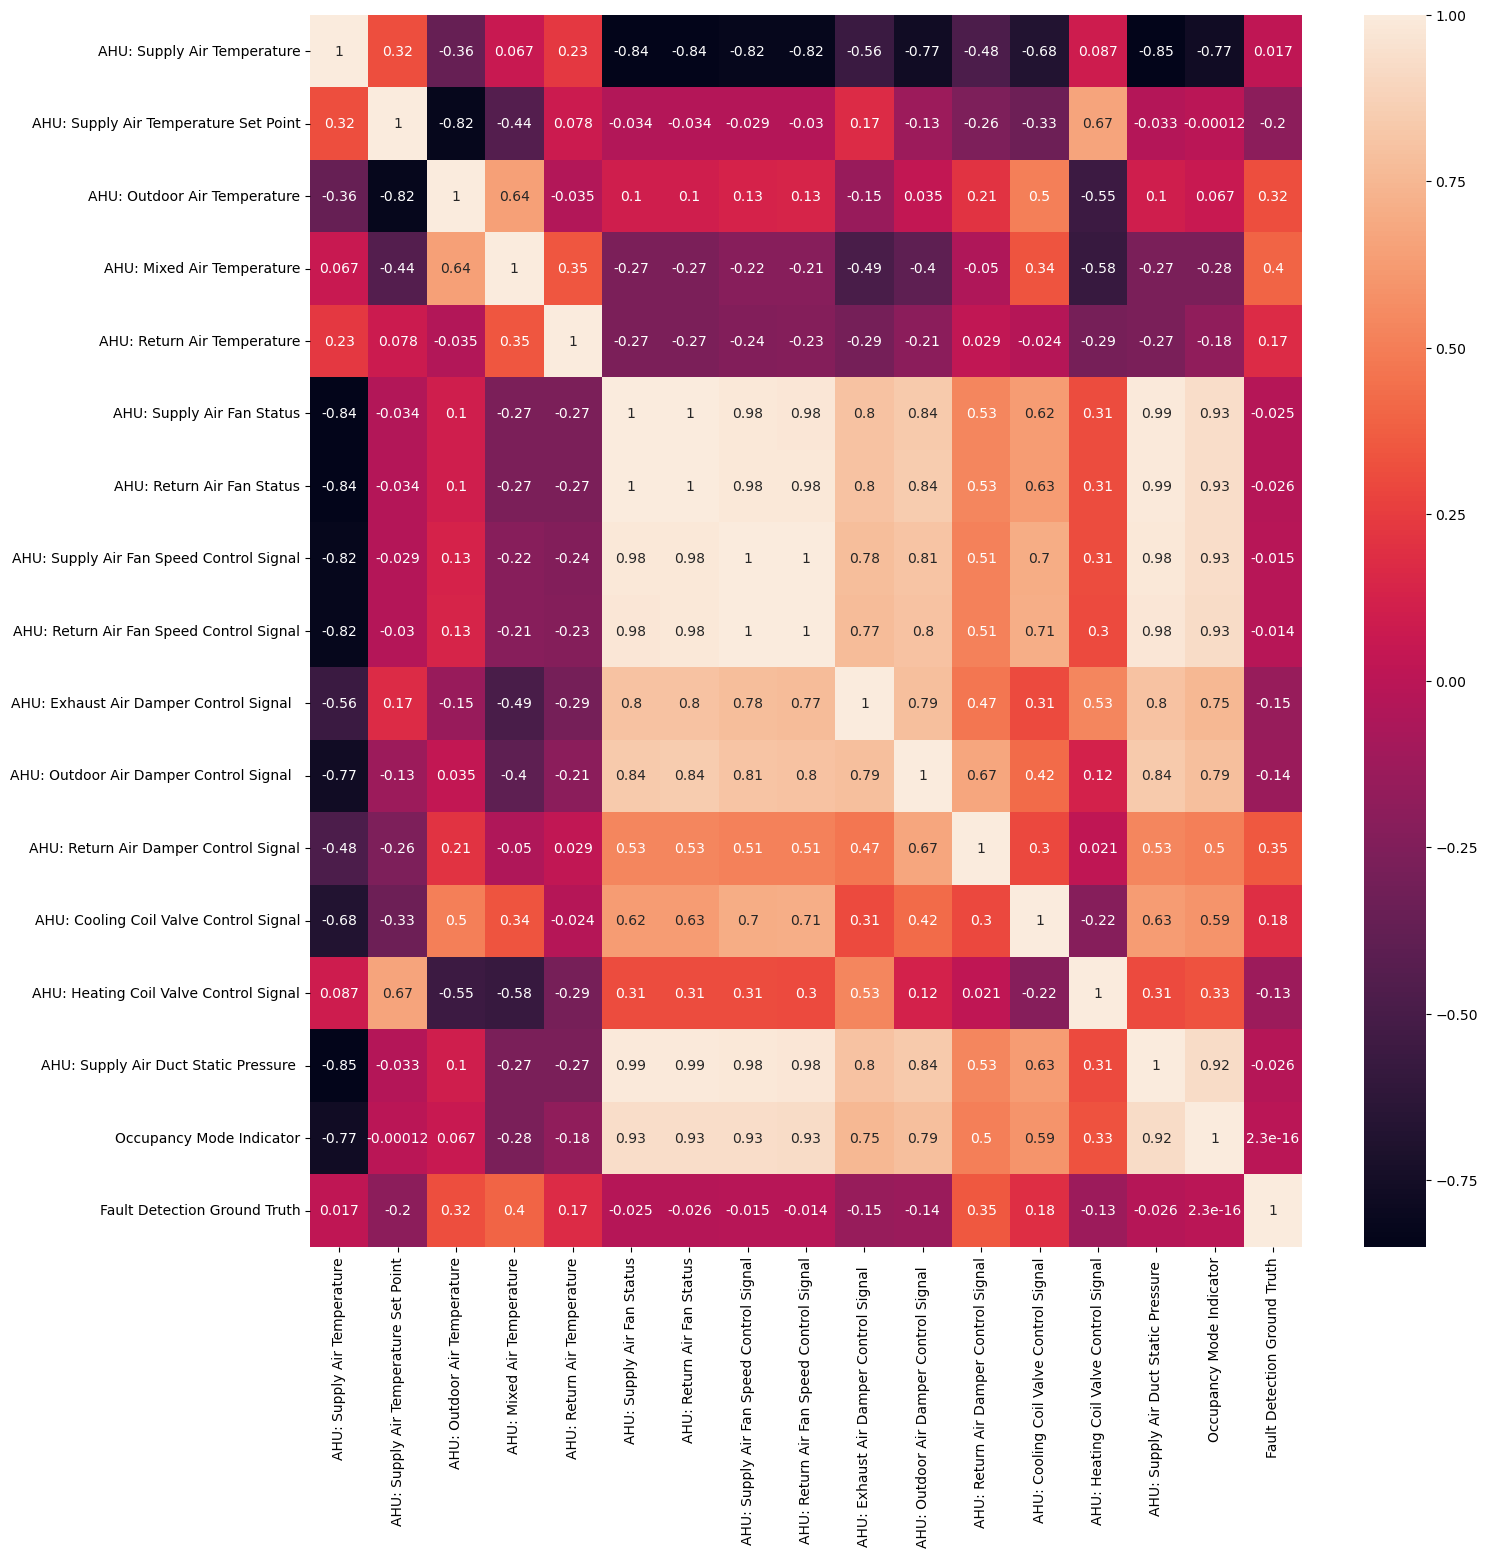

In [16]:
plt.figure(figsize=(16,16))
sns.heatmap(data_exp.corr(), annot=True)

Upon reviewing the dataset, it becomes evident that five columns—namely, "AHU: Supply Air Fan Status," "AHU: Return Air Fan Status," "AHU: Supply Air Fan Speed Control Signal," "AHU: Return Air Fan Speed Control Signal," and "AHU: Supply Air Duct Static Pressure"—exhibit significant correlation, likely attributed to the control sequence. To mitigate multicollinearity, it is rational to retain only one of these columns.

Notably, the dataset description indicates that fans are deactivated during unoccupied mode. Additionally, a strong correlation is evident between the occupancy mode indicator and the supply air fan status. Consequently, it is reasonable to omit the occupancy mode indicator column as well.

In [17]:
data_exp.drop(['AHU: Return Air Fan Status', 'AHU: Supply Air Fan Speed Control Signal','AHU: Return Air Fan Speed Control Signal',
                 'AHU: Supply Air Duct Static Pressure ', 'Occupancy Mode Indicator'], axis=1, inplace=True)

<AxesSubplot:>

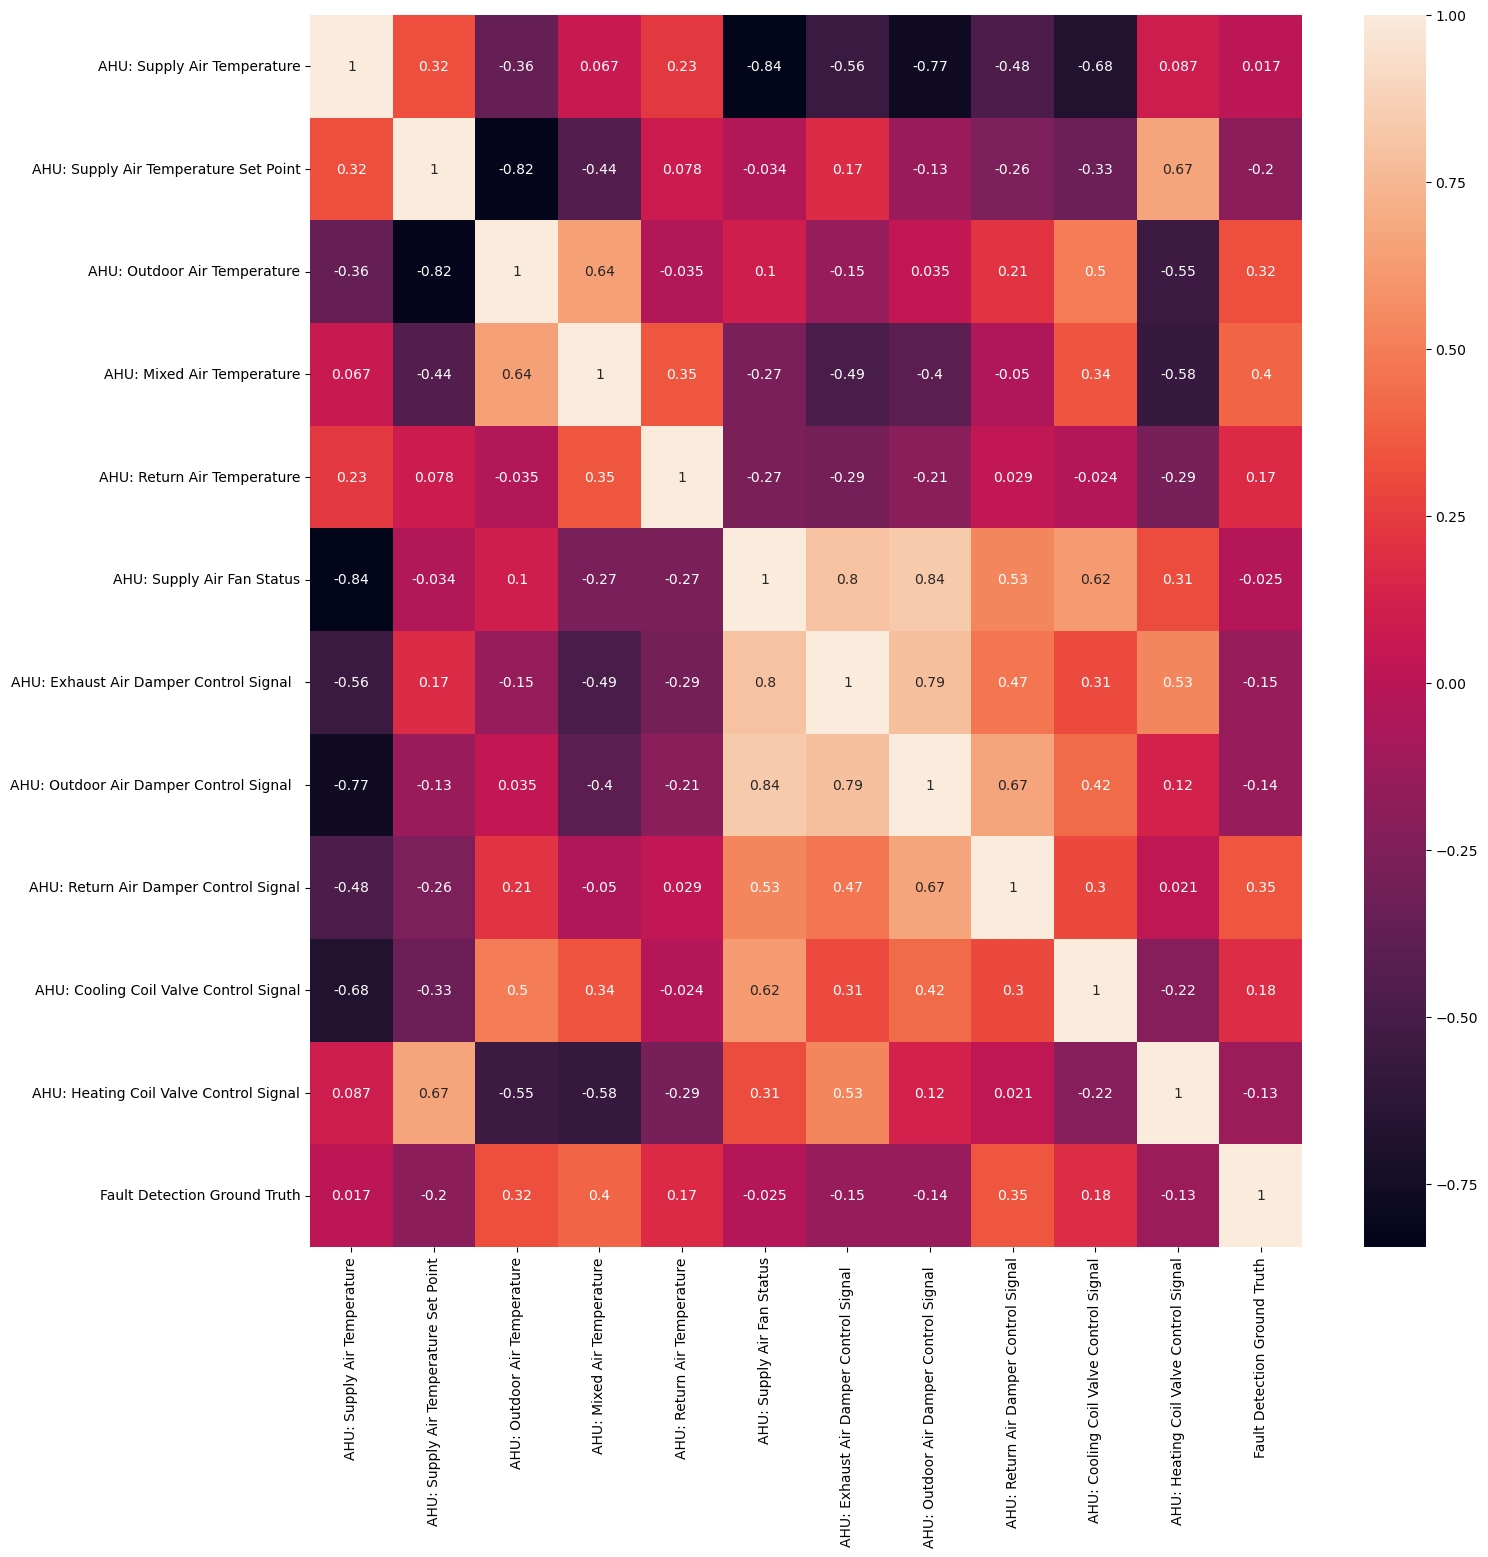

In [18]:
plt.figure(figsize=(16,16))
sns.heatmap(data_exp.corr(), annot=True)

The dataset appears to be ready for the subsequent model-building phase. In the heatmap above correlations involving the "Fault Detection Ground Truth" column and several other columns is visible. This correlation indicates that the "Fault Detection Ground Truth" column is well-suited as a target for a classification algorithm.

## Model building

### Feature and target data preparation

In [19]:
X_exp = data_exp.drop(['Datetime','Fault Detection Ground Truth'], axis=1)

In [20]:
y_exp = data_exp['Fault Detection Ground Truth']

In [21]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.1, shuffle=True)

### Classification model training

In [22]:
models_exp, Acc_exp = train_evaluate_classification_models(X_train_exp, X_test_exp, y_train_exp, y_test_exp, classifiers)

Learning rate set to 0.036577
0:	learn: 0.5792875	total: 267ms	remaining: 4m 26s
1:	learn: 0.4857724	total: 325ms	remaining: 2m 42s
2:	learn: 0.4071133	total: 383ms	remaining: 2m 7s
3:	learn: 0.3429626	total: 404ms	remaining: 1m 40s
4:	learn: 0.2938625	total: 468ms	remaining: 1m 33s
5:	learn: 0.2505114	total: 488ms	remaining: 1m 20s
6:	learn: 0.2160989	total: 571ms	remaining: 1m 21s
7:	learn: 0.1915531	total: 635ms	remaining: 1m 18s
8:	learn: 0.1711431	total: 682ms	remaining: 1m 15s
9:	learn: 0.1538906	total: 711ms	remaining: 1m 10s
10:	learn: 0.1372700	total: 754ms	remaining: 1m 7s
11:	learn: 0.1245326	total: 786ms	remaining: 1m 4s
12:	learn: 0.1135142	total: 805ms	remaining: 1m 1s
13:	learn: 0.1090328	total: 819ms	remaining: 57.7s
14:	learn: 0.1018219	total: 833ms	remaining: 54.7s
15:	learn: 0.0948918	total: 847ms	remaining: 52.1s
16:	learn: 0.0899196	total: 861ms	remaining: 49.8s
17:	learn: 0.0854400	total: 877ms	remaining: 47.8s
18:	learn: 0.0816170	total: 898ms	remaining: 46.4s
19

164:	learn: 0.0103649	total: 3.93s	remaining: 19.9s
165:	learn: 0.0103020	total: 3.95s	remaining: 19.8s
166:	learn: 0.0102331	total: 3.97s	remaining: 19.8s
167:	learn: 0.0101873	total: 3.99s	remaining: 19.7s
168:	learn: 0.0100986	total: 4.01s	remaining: 19.7s
169:	learn: 0.0099959	total: 4.03s	remaining: 19.7s
170:	learn: 0.0098979	total: 4.05s	remaining: 19.6s
171:	learn: 0.0098471	total: 4.07s	remaining: 19.6s
172:	learn: 0.0097348	total: 4.09s	remaining: 19.5s
173:	learn: 0.0096854	total: 4.11s	remaining: 19.5s
174:	learn: 0.0096193	total: 4.13s	remaining: 19.5s
175:	learn: 0.0095478	total: 4.15s	remaining: 19.4s
176:	learn: 0.0095208	total: 4.17s	remaining: 19.4s
177:	learn: 0.0094949	total: 4.19s	remaining: 19.3s
178:	learn: 0.0094179	total: 4.21s	remaining: 19.3s
179:	learn: 0.0093000	total: 4.25s	remaining: 19.3s
180:	learn: 0.0092595	total: 4.27s	remaining: 19.3s
181:	learn: 0.0092393	total: 4.29s	remaining: 19.3s
182:	learn: 0.0091954	total: 4.31s	remaining: 19.2s
183:	learn: 

324:	learn: 0.0042101	total: 7.98s	remaining: 16.6s
325:	learn: 0.0041941	total: 8s	remaining: 16.5s
326:	learn: 0.0041802	total: 8.02s	remaining: 16.5s
327:	learn: 0.0041494	total: 8.05s	remaining: 16.5s
328:	learn: 0.0041318	total: 8.07s	remaining: 16.5s
329:	learn: 0.0041160	total: 8.09s	remaining: 16.4s
330:	learn: 0.0040930	total: 8.11s	remaining: 16.4s
331:	learn: 0.0040690	total: 8.13s	remaining: 16.4s
332:	learn: 0.0040546	total: 8.15s	remaining: 16.3s
333:	learn: 0.0040408	total: 8.18s	remaining: 16.3s
334:	learn: 0.0040206	total: 8.2s	remaining: 16.3s
335:	learn: 0.0040082	total: 8.23s	remaining: 16.3s
336:	learn: 0.0039985	total: 8.25s	remaining: 16.2s
337:	learn: 0.0039712	total: 8.27s	remaining: 16.2s
338:	learn: 0.0039576	total: 8.31s	remaining: 16.2s
339:	learn: 0.0039349	total: 8.33s	remaining: 16.2s
340:	learn: 0.0039215	total: 8.36s	remaining: 16.2s
341:	learn: 0.0038951	total: 8.4s	remaining: 16.2s
342:	learn: 0.0038764	total: 8.43s	remaining: 16.2s
343:	learn: 0.003

491:	learn: 0.0024060	total: 13.1s	remaining: 13.5s
492:	learn: 0.0023976	total: 13.1s	remaining: 13.5s
493:	learn: 0.0023955	total: 13.1s	remaining: 13.4s
494:	learn: 0.0023914	total: 13.2s	remaining: 13.4s
495:	learn: 0.0023807	total: 13.2s	remaining: 13.4s
496:	learn: 0.0023677	total: 13.2s	remaining: 13.4s
497:	learn: 0.0023604	total: 13.3s	remaining: 13.4s
498:	learn: 0.0023570	total: 13.3s	remaining: 13.3s
499:	learn: 0.0023544	total: 13.4s	remaining: 13.4s
500:	learn: 0.0023513	total: 13.4s	remaining: 13.3s
501:	learn: 0.0023468	total: 13.4s	remaining: 13.3s
502:	learn: 0.0023363	total: 13.4s	remaining: 13.3s
503:	learn: 0.0023275	total: 13.5s	remaining: 13.3s
504:	learn: 0.0023225	total: 13.5s	remaining: 13.2s
505:	learn: 0.0023171	total: 13.6s	remaining: 13.2s
506:	learn: 0.0023124	total: 13.6s	remaining: 13.2s
507:	learn: 0.0023054	total: 13.6s	remaining: 13.2s
508:	learn: 0.0023019	total: 13.7s	remaining: 13.2s
509:	learn: 0.0022951	total: 13.8s	remaining: 13.3s
510:	learn: 

665:	learn: 0.0017829	total: 17.5s	remaining: 8.79s
666:	learn: 0.0017829	total: 17.5s	remaining: 8.76s
667:	learn: 0.0017829	total: 17.6s	remaining: 8.73s
668:	learn: 0.0017829	total: 17.6s	remaining: 8.7s
669:	learn: 0.0017829	total: 17.6s	remaining: 8.67s
670:	learn: 0.0017829	total: 17.6s	remaining: 8.63s
671:	learn: 0.0017829	total: 17.6s	remaining: 8.61s
672:	learn: 0.0017829	total: 17.6s	remaining: 8.57s
673:	learn: 0.0017829	total: 17.7s	remaining: 8.55s
674:	learn: 0.0017829	total: 17.7s	remaining: 8.52s
675:	learn: 0.0017829	total: 17.7s	remaining: 8.5s
676:	learn: 0.0017829	total: 17.7s	remaining: 8.47s
677:	learn: 0.0017829	total: 17.8s	remaining: 8.44s
678:	learn: 0.0017829	total: 17.8s	remaining: 8.4s
679:	learn: 0.0017829	total: 17.8s	remaining: 8.37s
680:	learn: 0.0017829	total: 17.8s	remaining: 8.34s
681:	learn: 0.0017829	total: 17.8s	remaining: 8.3s
682:	learn: 0.0017829	total: 17.8s	remaining: 8.27s
683:	learn: 0.0017829	total: 17.8s	remaining: 8.24s
684:	learn: 0.00

830:	learn: 0.0017829	total: 21.4s	remaining: 4.36s
831:	learn: 0.0017829	total: 21.4s	remaining: 4.33s
832:	learn: 0.0017829	total: 21.5s	remaining: 4.3s
833:	learn: 0.0017829	total: 21.5s	remaining: 4.29s
834:	learn: 0.0017829	total: 21.5s	remaining: 4.26s
835:	learn: 0.0017829	total: 21.6s	remaining: 4.23s
836:	learn: 0.0017829	total: 21.6s	remaining: 4.21s
837:	learn: 0.0017829	total: 21.7s	remaining: 4.19s
838:	learn: 0.0017829	total: 21.7s	remaining: 4.16s
839:	learn: 0.0017829	total: 21.7s	remaining: 4.13s
840:	learn: 0.0017829	total: 21.8s	remaining: 4.12s
841:	learn: 0.0017829	total: 21.8s	remaining: 4.09s
842:	learn: 0.0017829	total: 21.8s	remaining: 4.06s
843:	learn: 0.0017829	total: 21.8s	remaining: 4.03s
844:	learn: 0.0017829	total: 21.8s	remaining: 4.01s
845:	learn: 0.0017829	total: 21.9s	remaining: 3.98s
846:	learn: 0.0017829	total: 21.9s	remaining: 3.95s
847:	learn: 0.0017829	total: 21.9s	remaining: 3.92s
848:	learn: 0.0017829	total: 21.9s	remaining: 3.9s
849:	learn: 0.

993:	learn: 0.0017829	total: 24.6s	remaining: 149ms
994:	learn: 0.0017829	total: 24.7s	remaining: 124ms
995:	learn: 0.0017829	total: 24.7s	remaining: 99.2ms
996:	learn: 0.0017829	total: 24.7s	remaining: 74.4ms
997:	learn: 0.0017829	total: 24.8s	remaining: 49.6ms
998:	learn: 0.0017829	total: 24.8s	remaining: 24.8ms
999:	learn: 0.0017829	total: 24.8s	remaining: 0us


### Models evaluation

In [23]:
print(Acc_exp)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.997171       0.994907         0.991403   
1               MLPClassifier        0.967335       0.965741         0.992868   
2          AdaBoostClassifier        0.992695       0.990741         0.972741   
3  GradientBoostingClassifier        0.994444       0.993981         0.969847   
4          CatBoostClassifier        1.000000       0.999074         1.000000   
5               XGBClassifier        1.000000       0.997685         1.000000   
6           BaggingClassifier        0.999897       0.998611         1.000000   
7      RandomForestClassifier        1.000000       0.999074         1.000000   
8      DecisionTreeClassifier        1.000000       0.997685         1.000000   
9          LogisticRegression        0.931121       0.931481         0.765416   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.986971      0.987160     0.977

The outcomes highlight the remarkable performance of most models in this task, even without balancing or fine-tuning efforts. Interestingly, even the Logistic Regression model exhibits relatively strong performance. This trend suggests that the relationships between features and target data are easily recognizable, and the dataset is well-prepared. This implies that utilizing machine learning models for detecting such faults is likely to be straightforward and practical, as long as we have high quality data.

Creating such a system, however, would necessitate a sequence of functional tests, and good procedures to produce such high quality data, and this process could be costly. However, the ultimate result would be an exceptionally effective tool for fault detection, a solution with the potential of substantial benefits. These benefits could notably outweigh the implementation costs, particularly when contrasted with the financial consequences of overlooked faults or inefficiencies in the building management system.

### Feature importances

<BarContainer object of 11 artists>

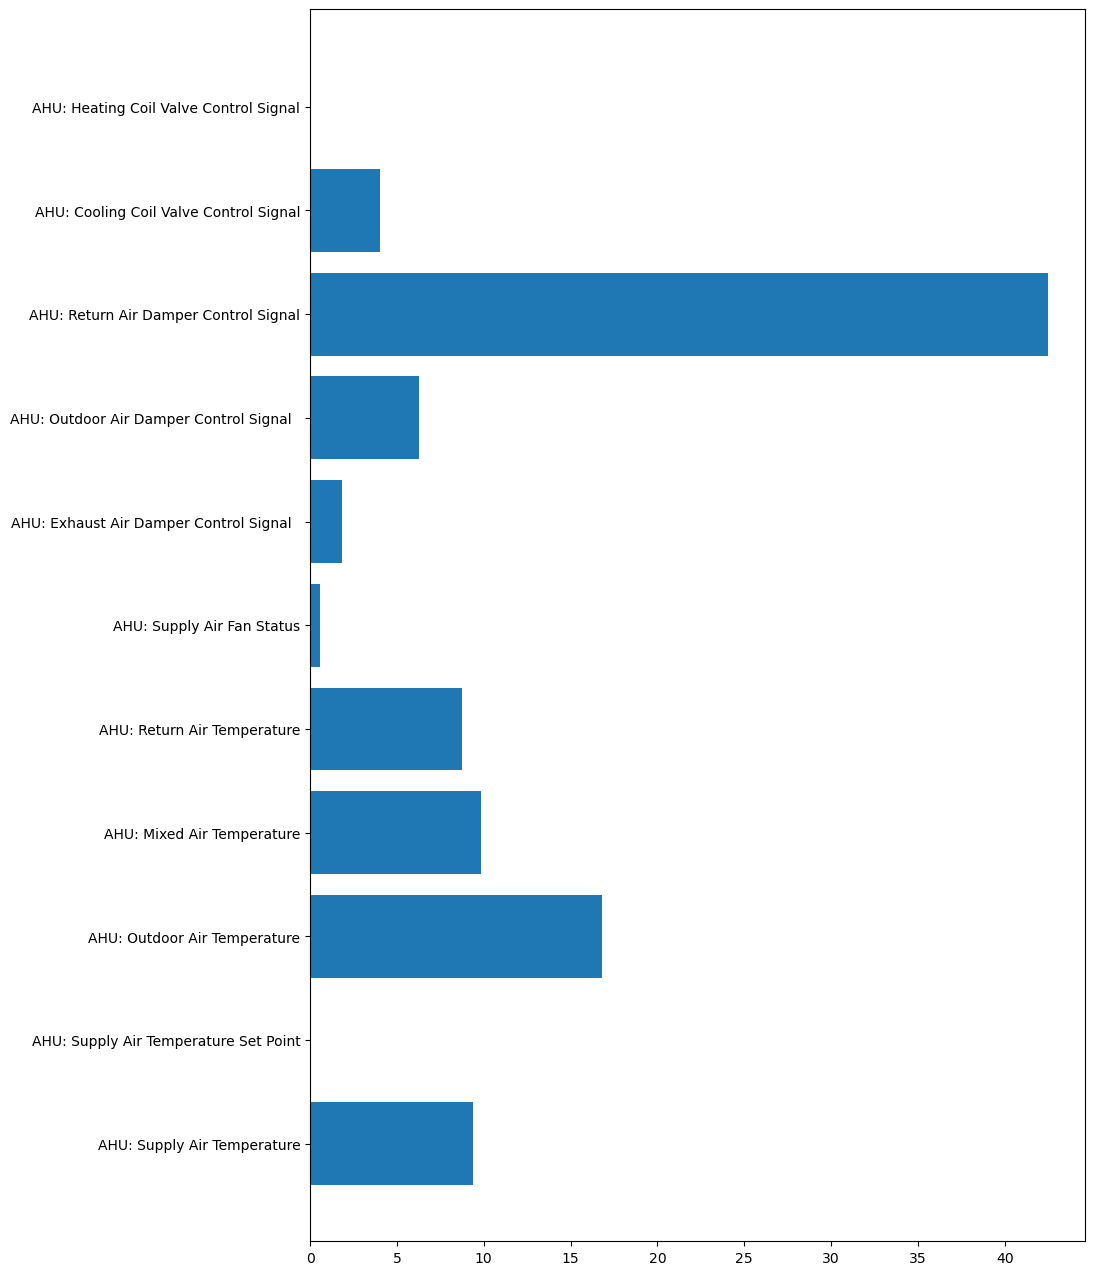

In [24]:
plt.figure(figsize=(10,16))
plt.barh(X_exp.columns, models_exp[4].get_feature_importance())

An intriguing observation emerges from the above graph: the heating coil valve signal holds minimal importance in detecting faults associated with it. This unexpected finding could imply that the faulty element's behavior doesn't inherently offer direct clues about its malfunction. Instead, fault indications likely arise from the atypical behaviors of other components. For instance, the cold valve signal carries more significance, potentially because a faulty heating valve might lead to increased demand for cooling, intensifying the cold valve's activity.

This insight underscores the complex interplay between system components and their fault indicators. It emphasizes the need to consider not only the individual behavior of components but also their collective responses in identifying anomalies and failures. It also highlights the usefulness of machine learning tools.

# Simulated dataset

## Data exploration and feature engineering

In [25]:
raw_data_sim.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
5622,8/31/2007 21:42,55.76,55,70.09,67.62,67.54,1,0,1.00,0.00,0.0,0.0,1.0,0.00,0.0,1.4,3.59,0,1
26622,9/1/2008 11:42,54.96,55,80.14,74.42,72.00,1,1,0.72,0.57,0.4,0.4,0.6,0.49,0.0,1.4,1.33,1,0
31324,2/11/2009 18:04,66.24,55,7.80,7.80,57.04,0,0,0.00,0.00,0.0,0.0,1.0,0.00,0.0,1.4,0.01,0,0
6949,9/1/2007 19:49,42.66,55,73.66,73.66,68.23,0,0,0.00,0.00,0.0,0.0,1.0,0.00,0.0,1.4,0.01,0,1
9139,9/5/2007 8:19,55.20,55,72.04,74.75,72.51,1,1,1.00,1.00,0.4,0.4,0.6,0.45,0.0,1.4,4.15,1,1


In [26]:
raw_data_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37440 entries, 0 to 37439
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Datetime                                        37440 non-null  object 
 1   AHU: Supply Air Temperature                     37440 non-null  float64
 2   AHU: Supply Air Temperature Set Point           37440 non-null  int64  
 3   AHU: Outdoor Air Temperature                    37440 non-null  float64
 4   AHU: Mixed Air Temperature                      37440 non-null  float64
 5   AHU: Return Air Temperature                     37440 non-null  float64
 6   AHU: Supply Air Fan Status                      37440 non-null  int64  
 7   AHU: Return Air Fan Status                      37440 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        37440 non-null  float64
 9   AHU: Return Air Fan Speed Control Signa

It appears that the dataset is free from any major cleaning requirements, except for the modification of the "Datetime" column's datatype to datetime. 

In [27]:
raw_data_sim['Datetime'] = pd.to_datetime(raw_data_sim['Datetime'])

In [28]:
raw_data_sim.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,3.744000e+04,37440.000000,37440.000000,37440.000000
mean,63.237180,55.662126,64.445303,66.916624,68.218243,0.653846,0.500000,0.568830,0.362148,0.286949,0.286949,0.713051,0.203983,0.050786,1.400000e+00,1.343421,0.500000,0.500000
std,11.940915,2.486567,18.987496,14.653489,7.483220,0.475749,0.500007,0.430636,0.387902,0.340170,0.340170,0.340170,0.286489,0.206367,9.201651e-13,1.409967,0.500007,0.500007
min,23.850000,55.000000,1.540000,1.540000,50.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000e+00,-0.490000,0.000000,0.000000
25%,54.980000,55.000000,60.677500,63.360000,60.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,1.400000e+00,0.010000,0.000000,0.000000
50%,60.805000,55.000000,68.470000,71.300000,71.180000,1.000000,0.500000,0.710000,0.240000,0.400000,0.400000,0.600000,0.000000,0.000000,1.400000e+00,1.350000,0.500000,0.500000
75%,71.850000,55.000000,75.582500,74.270000,72.110000,1.000000,1.000000,1.000000,0.580000,0.400000,0.400000,1.000000,0.470000,0.000000,1.400000e+00,1.780000,1.000000,1.000000
max,107.940000,65.000000,91.850000,90.300000,90.870000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.400000e+00,5.010000,1.000000,1.000000


In [29]:
# Making copy of dataset for further data transformation
data_sim = raw_data_sim.copy()

AHU: Supply Air Duct Static Pressure Set Point column has constant values so it should be excluded from the dataset.

In [30]:
data_sim.drop('AHU: Supply Air Duct Static Pressure Set Point', axis=1, inplace=True)

<AxesSubplot:>

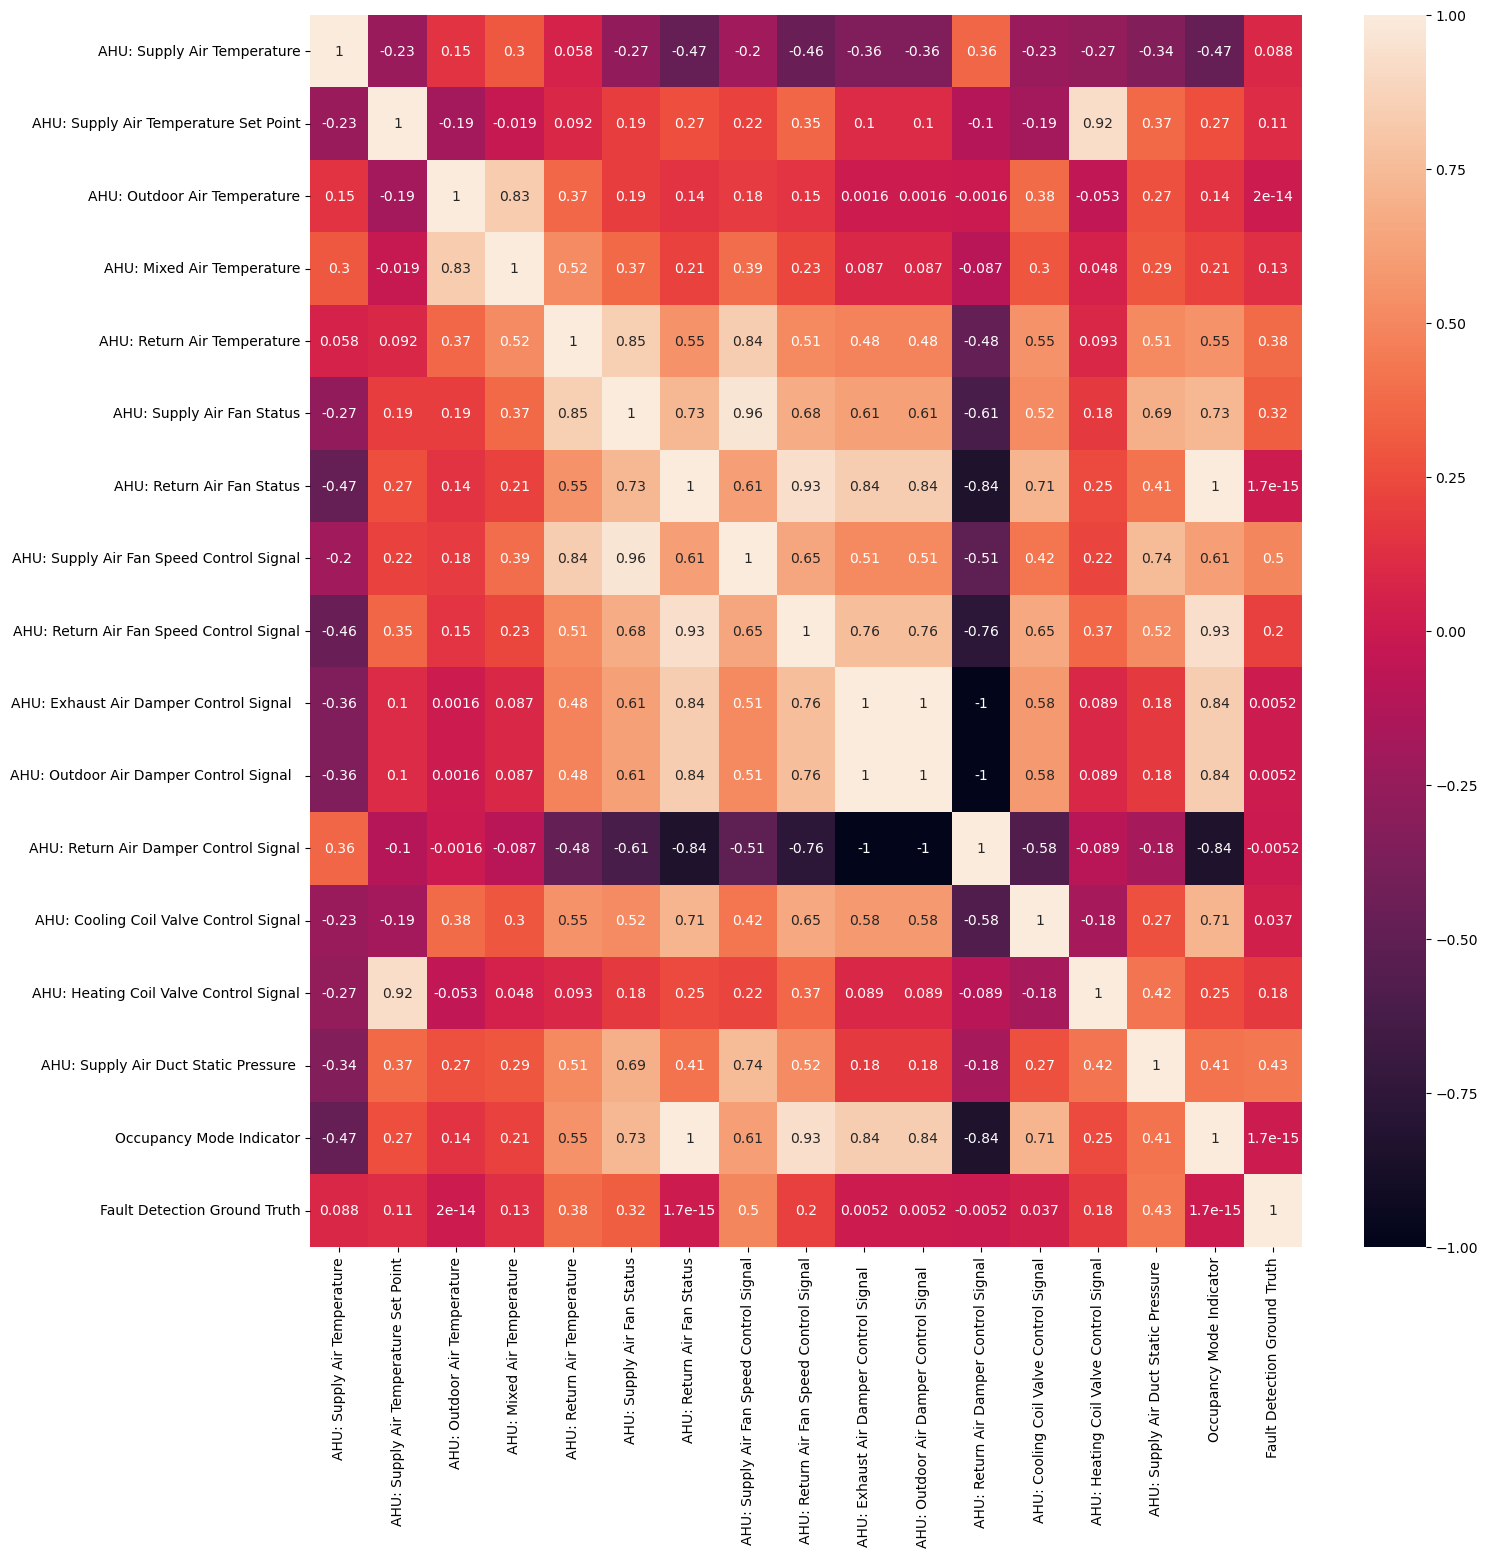

In [31]:
plt.figure(figsize=(16,16))
sns.heatmap(data_sim.corr(), annot=True)

The "AHU: Supply Air Fan Status" and "Occupancy Mode Indicator" columns exhibit complete correlation, rendering it unnecessary to retain both. Therefore, only the "AHU: Supply Air Fan Status" column will be retained.

Among the columns "AHU: Exhaust Air Damper Control Signal," "AHU: Outdoor Air Damper Control Signal," and "AHU: Return Air Damper Control Signal," a 100% correlation is also evident, necessitating the preservation of only one. Hence, the "AHU: Exhaust Air Damper Control Signal" column will be retained.

These modifications align with the objective of refining the dataset for analysis and modeling by removing redundant and correlated features.

In [32]:
data_sim.drop(['Occupancy Mode Indicator','AHU: Outdoor Air Damper Control Signal  ','AHU: Return Air Damper Control Signal'], axis=1,inplace=True)

<AxesSubplot:>

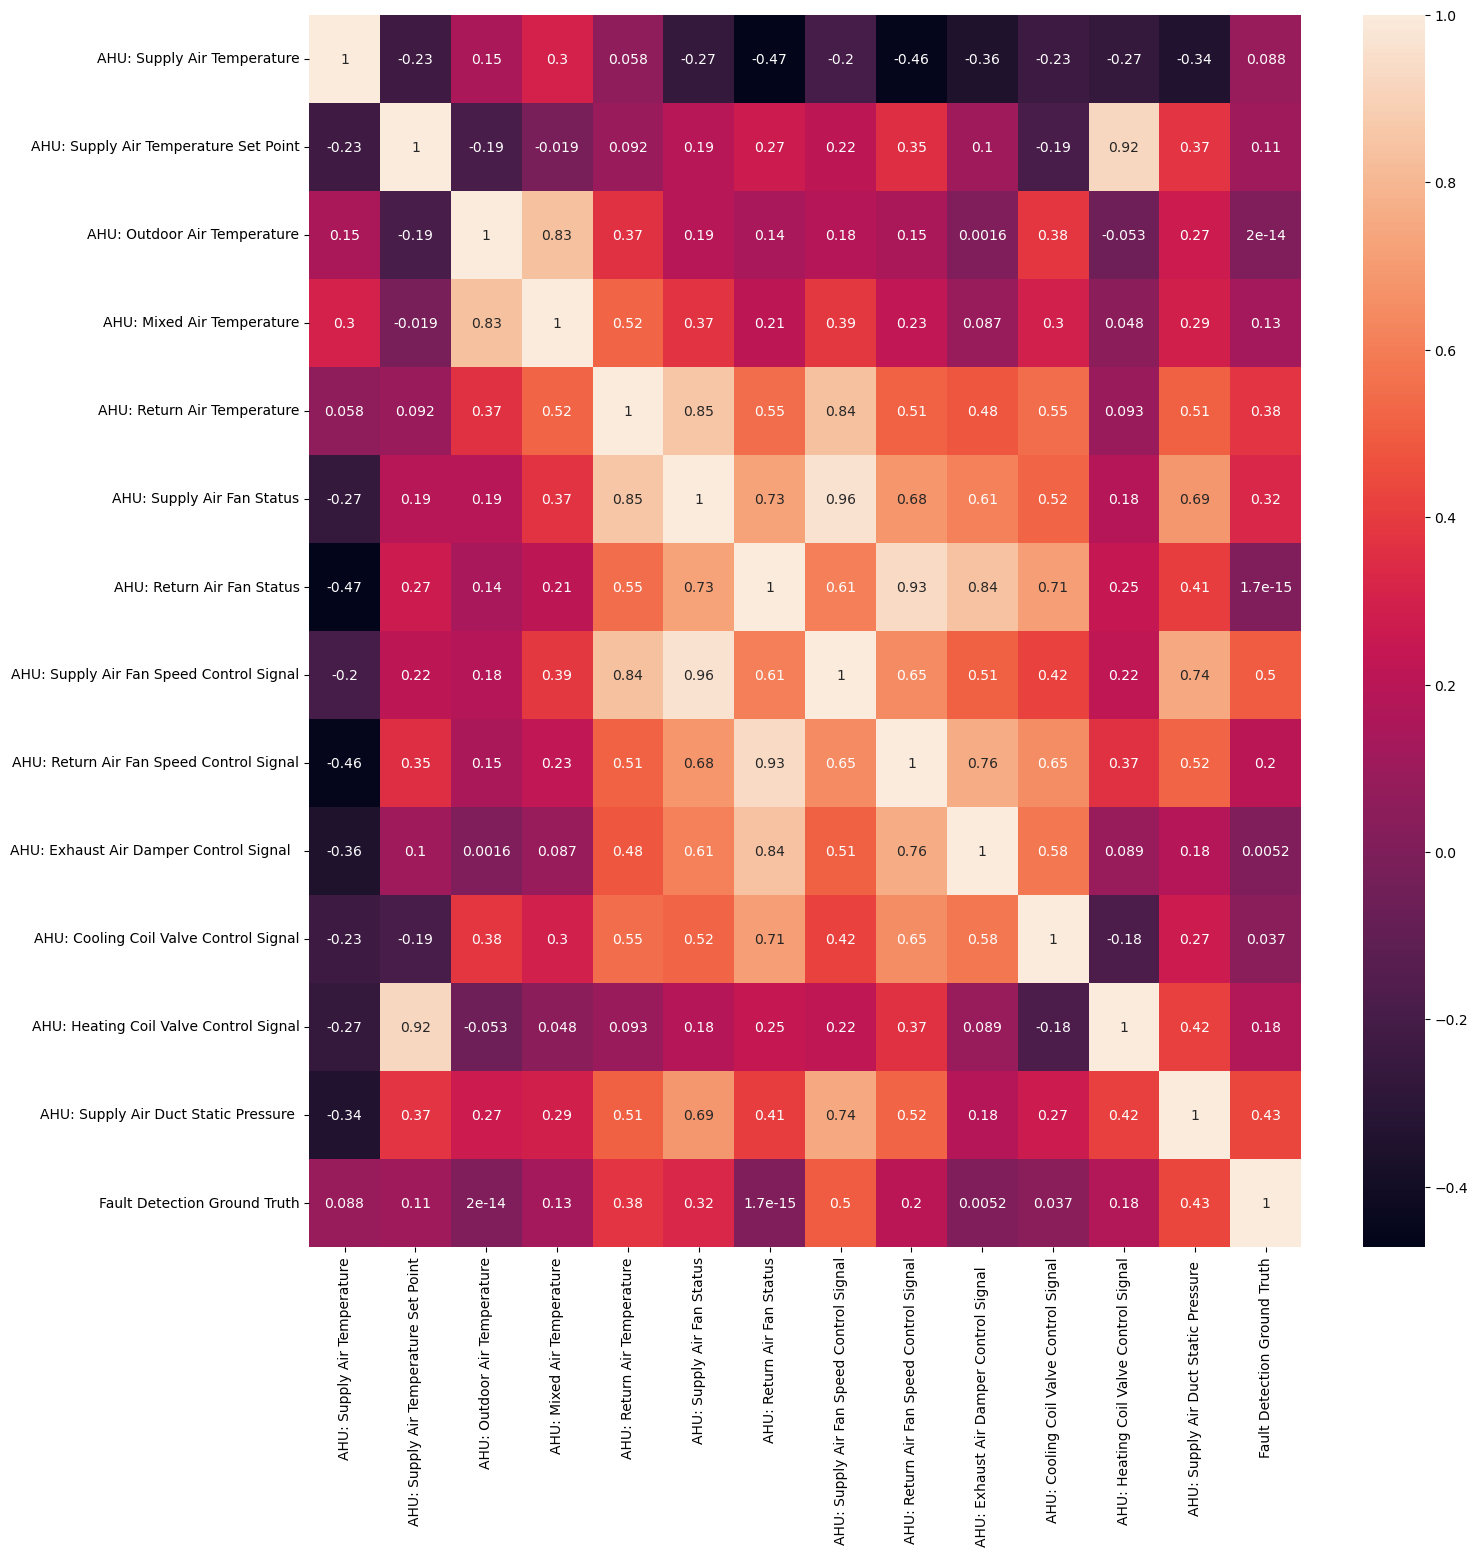

In [33]:
plt.figure(figsize=(16,16))
sns.heatmap(data_sim.corr(), annot=True)

The dataset appears to be well-prepared for the subsequent phase of model building. The "Fault Detection Ground Truth" column exhibits correlations with certain other columns. However, upon closer inspection of the dataset description, it becomes evident that this column encompasses a diverse array of fault types. Taking that into consideration it holds greater value to discern not only the presence of a fault but also the specific fault type. Consequently, three distinct target columns will be prepared to do this. This alteration enables a more nuanced and informative modeling approach.

In [34]:
def convert_date(date_str):
    return pd.to_datetime(date_str, format='%m/%d/%Y')

In [35]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('2/12/2008'), 
                  convert_date('5/7/2008'), 
                  convert_date('5/8/2008'), 
                  convert_date('9/5/2007'), 
                  convert_date('9/6/2007')]
heat_vlv_fault_dates = [convert_date('8/28/2007'), 
                        convert_date('8/29/2007'), 
                        convert_date('8/30/2007')]
cool_vlv_fault_dates = [convert_date('5/6/2008'), 
                        convert_date('8/31/2007'), 
                        convert_date('5/15/2008'),
                        convert_date('9/1/2007'),
                        convert_date('9/2/2007')]

In [36]:
# Creating and filling fault column with values according to the dates given earlier.
data_sim['OA_fault'] = 0
data_sim['heat_vlv_fault'] = 0
data_sim['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_sim.loc[data_sim['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [37]:
X_sim = data_sim.drop(['Datetime','Fault Detection Ground Truth','OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [38]:
y_oa = data_sim['OA_fault']
y_heat = data_sim['heat_vlv_fault']
y_cool = data_sim['cool_vlv_fault']

In [39]:
X_train_oa, X_test_oa, y_train_oa, y_test_oa = train_test_split(X_sim, y_oa, test_size=0.1, shuffle=True)
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(X_sim, y_heat, test_size=0.1, shuffle=True)
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(X_sim, y_cool, test_size=0.1, shuffle=True)

### Classification model training

In [40]:
models_oa, Acc_oa = train_evaluate_classification_models(X_train_oa, X_test_oa, y_train_oa, y_test_oa, classifiers)
models_heat, Acc_heat = train_evaluate_classification_models(X_train_heat, X_test_heat, y_train_heat, y_test_heat, classifiers)
models_cool, Acc_cool = train_evaluate_classification_models(X_train_cool, X_test_cool, y_train_cool, y_test_cool, classifiers)

Learning rate set to 0.04626
0:	learn: 0.6216648	total: 31.5ms	remaining: 31.4s
1:	learn: 0.5461678	total: 61.6ms	remaining: 30.7s
2:	learn: 0.4939721	total: 84.1ms	remaining: 28s
3:	learn: 0.4434904	total: 108ms	remaining: 26.8s
4:	learn: 0.4084995	total: 130ms	remaining: 25.8s
5:	learn: 0.3727985	total: 153ms	remaining: 25.3s
6:	learn: 0.3449785	total: 178ms	remaining: 25.2s
7:	learn: 0.3200382	total: 200ms	remaining: 24.8s
8:	learn: 0.2960159	total: 236ms	remaining: 26s
9:	learn: 0.2771085	total: 261ms	remaining: 25.8s
10:	learn: 0.2622003	total: 284ms	remaining: 25.5s
11:	learn: 0.2509146	total: 310ms	remaining: 25.6s
12:	learn: 0.2346804	total: 335ms	remaining: 25.4s
13:	learn: 0.2253776	total: 360ms	remaining: 25.3s
14:	learn: 0.2123905	total: 391ms	remaining: 25.6s
15:	learn: 0.2031794	total: 427ms	remaining: 26.3s
16:	learn: 0.1978038	total: 464ms	remaining: 26.8s
17:	learn: 0.1911338	total: 488ms	remaining: 26.6s
18:	learn: 0.1858401	total: 512ms	remaining: 26.4s
19:	learn: 0.

162:	learn: 0.0487363	total: 4.2s	remaining: 21.6s
163:	learn: 0.0486201	total: 4.23s	remaining: 21.6s
164:	learn: 0.0485288	total: 4.25s	remaining: 21.5s
165:	learn: 0.0483179	total: 4.28s	remaining: 21.5s
166:	learn: 0.0482366	total: 4.3s	remaining: 21.4s
167:	learn: 0.0481163	total: 4.32s	remaining: 21.4s
168:	learn: 0.0480119	total: 4.35s	remaining: 21.4s
169:	learn: 0.0478766	total: 4.37s	remaining: 21.3s
170:	learn: 0.0477497	total: 4.39s	remaining: 21.3s
171:	learn: 0.0476772	total: 4.42s	remaining: 21.3s
172:	learn: 0.0475376	total: 4.45s	remaining: 21.3s
173:	learn: 0.0472833	total: 4.47s	remaining: 21.2s
174:	learn: 0.0471644	total: 4.5s	remaining: 21.2s
175:	learn: 0.0470553	total: 4.52s	remaining: 21.2s
176:	learn: 0.0469734	total: 4.54s	remaining: 21.1s
177:	learn: 0.0468263	total: 4.57s	remaining: 21.1s
178:	learn: 0.0465703	total: 4.59s	remaining: 21.1s
179:	learn: 0.0465187	total: 4.63s	remaining: 21.1s
180:	learn: 0.0463640	total: 4.66s	remaining: 21.1s
181:	learn: 0.0

327:	learn: 0.0353480	total: 8.67s	remaining: 17.8s
328:	learn: 0.0352667	total: 8.7s	remaining: 17.7s
329:	learn: 0.0351991	total: 8.72s	remaining: 17.7s
330:	learn: 0.0351203	total: 8.75s	remaining: 17.7s
331:	learn: 0.0350507	total: 8.78s	remaining: 17.7s
332:	learn: 0.0350107	total: 8.8s	remaining: 17.6s
333:	learn: 0.0349605	total: 8.85s	remaining: 17.6s
334:	learn: 0.0349384	total: 8.88s	remaining: 17.6s
335:	learn: 0.0349137	total: 8.92s	remaining: 17.6s
336:	learn: 0.0348850	total: 8.95s	remaining: 17.6s
337:	learn: 0.0348149	total: 8.98s	remaining: 17.6s
338:	learn: 0.0347953	total: 9s	remaining: 17.6s
339:	learn: 0.0347788	total: 9.03s	remaining: 17.5s
340:	learn: 0.0347386	total: 9.06s	remaining: 17.5s
341:	learn: 0.0346707	total: 9.09s	remaining: 17.5s
342:	learn: 0.0346395	total: 9.13s	remaining: 17.5s
343:	learn: 0.0345932	total: 9.16s	remaining: 17.5s
344:	learn: 0.0345669	total: 9.21s	remaining: 17.5s
345:	learn: 0.0345355	total: 9.23s	remaining: 17.5s
346:	learn: 0.034

487:	learn: 0.0315017	total: 13.1s	remaining: 13.7s
488:	learn: 0.0314916	total: 13.1s	remaining: 13.7s
489:	learn: 0.0314759	total: 13.1s	remaining: 13.7s
490:	learn: 0.0314529	total: 13.2s	remaining: 13.6s
491:	learn: 0.0314497	total: 13.2s	remaining: 13.6s
492:	learn: 0.0314402	total: 13.2s	remaining: 13.6s
493:	learn: 0.0314319	total: 13.3s	remaining: 13.6s
494:	learn: 0.0314227	total: 13.3s	remaining: 13.6s
495:	learn: 0.0313905	total: 13.3s	remaining: 13.6s
496:	learn: 0.0313614	total: 13.4s	remaining: 13.5s
497:	learn: 0.0313539	total: 13.4s	remaining: 13.5s
498:	learn: 0.0313398	total: 13.4s	remaining: 13.5s
499:	learn: 0.0313247	total: 13.5s	remaining: 13.5s
500:	learn: 0.0313172	total: 13.5s	remaining: 13.4s
501:	learn: 0.0313009	total: 13.5s	remaining: 13.4s
502:	learn: 0.0312783	total: 13.5s	remaining: 13.4s
503:	learn: 0.0312649	total: 13.6s	remaining: 13.4s
504:	learn: 0.0312510	total: 13.6s	remaining: 13.3s
505:	learn: 0.0312356	total: 13.6s	remaining: 13.3s
506:	learn: 

654:	learn: 0.0299707	total: 17.5s	remaining: 9.2s
655:	learn: 0.0299707	total: 17.5s	remaining: 9.18s
656:	learn: 0.0299707	total: 17.5s	remaining: 9.15s
657:	learn: 0.0299707	total: 17.5s	remaining: 9.12s
658:	learn: 0.0299707	total: 17.6s	remaining: 9.09s
659:	learn: 0.0299707	total: 17.6s	remaining: 9.05s
660:	learn: 0.0299707	total: 17.6s	remaining: 9.03s
661:	learn: 0.0299707	total: 17.6s	remaining: 9s
662:	learn: 0.0299707	total: 17.6s	remaining: 8.96s
663:	learn: 0.0299707	total: 17.7s	remaining: 8.94s
664:	learn: 0.0299707	total: 17.7s	remaining: 8.9s
665:	learn: 0.0299707	total: 17.7s	remaining: 8.88s
666:	learn: 0.0299707	total: 17.7s	remaining: 8.85s
667:	learn: 0.0299707	total: 17.8s	remaining: 8.82s
668:	learn: 0.0299707	total: 17.8s	remaining: 8.79s
669:	learn: 0.0299707	total: 17.8s	remaining: 8.77s
670:	learn: 0.0299707	total: 17.8s	remaining: 8.74s
671:	learn: 0.0299707	total: 17.9s	remaining: 8.72s
672:	learn: 0.0299707	total: 17.9s	remaining: 8.69s
673:	learn: 0.029

813:	learn: 0.0299011	total: 21.1s	remaining: 4.82s
814:	learn: 0.0298977	total: 21.2s	remaining: 4.8s
815:	learn: 0.0298977	total: 21.2s	remaining: 4.78s
816:	learn: 0.0298977	total: 21.2s	remaining: 4.76s
817:	learn: 0.0298977	total: 21.3s	remaining: 4.73s
818:	learn: 0.0298977	total: 21.3s	remaining: 4.7s
819:	learn: 0.0298977	total: 21.3s	remaining: 4.68s
820:	learn: 0.0298977	total: 21.3s	remaining: 4.65s
821:	learn: 0.0298977	total: 21.4s	remaining: 4.63s
822:	learn: 0.0298977	total: 21.4s	remaining: 4.61s
823:	learn: 0.0298977	total: 21.4s	remaining: 4.58s
824:	learn: 0.0298825	total: 21.5s	remaining: 4.56s
825:	learn: 0.0298825	total: 21.5s	remaining: 4.53s
826:	learn: 0.0298825	total: 21.5s	remaining: 4.5s
827:	learn: 0.0298825	total: 21.6s	remaining: 4.48s
828:	learn: 0.0298825	total: 21.6s	remaining: 4.45s
829:	learn: 0.0298824	total: 21.6s	remaining: 4.43s
830:	learn: 0.0298825	total: 21.6s	remaining: 4.4s
831:	learn: 0.0298825	total: 21.7s	remaining: 4.37s
832:	learn: 0.02

976:	learn: 0.0295088	total: 25.3s	remaining: 595ms
977:	learn: 0.0295088	total: 25.3s	remaining: 569ms
978:	learn: 0.0295088	total: 25.3s	remaining: 543ms
979:	learn: 0.0295088	total: 25.3s	remaining: 517ms
980:	learn: 0.0295088	total: 25.4s	remaining: 491ms
981:	learn: 0.0295088	total: 25.4s	remaining: 465ms
982:	learn: 0.0295088	total: 25.4s	remaining: 439ms
983:	learn: 0.0295088	total: 25.4s	remaining: 414ms
984:	learn: 0.0295088	total: 25.5s	remaining: 388ms
985:	learn: 0.0295088	total: 25.5s	remaining: 362ms
986:	learn: 0.0295088	total: 25.5s	remaining: 336ms
987:	learn: 0.0295002	total: 25.5s	remaining: 310ms
988:	learn: 0.0294998	total: 25.5s	remaining: 284ms
989:	learn: 0.0294998	total: 25.6s	remaining: 258ms
990:	learn: 0.0294998	total: 25.6s	remaining: 232ms
991:	learn: 0.0294998	total: 25.6s	remaining: 207ms
992:	learn: 0.0294998	total: 25.6s	remaining: 181ms
993:	learn: 0.0294998	total: 25.7s	remaining: 155ms
994:	learn: 0.0294998	total: 25.7s	remaining: 129ms
995:	learn: 

137:	learn: 0.0257925	total: 4.04s	remaining: 25.2s
138:	learn: 0.0256519	total: 4.07s	remaining: 25.2s
139:	learn: 0.0254727	total: 4.09s	remaining: 25.1s
140:	learn: 0.0253578	total: 4.12s	remaining: 25.1s
141:	learn: 0.0252429	total: 4.14s	remaining: 25s
142:	learn: 0.0250249	total: 4.17s	remaining: 25s
143:	learn: 0.0248621	total: 4.2s	remaining: 25s
144:	learn: 0.0246722	total: 4.23s	remaining: 24.9s
145:	learn: 0.0244770	total: 4.25s	remaining: 24.9s
146:	learn: 0.0242987	total: 4.28s	remaining: 24.8s
147:	learn: 0.0240991	total: 4.31s	remaining: 24.8s
148:	learn: 0.0239363	total: 4.34s	remaining: 24.8s
149:	learn: 0.0237171	total: 4.37s	remaining: 24.8s
150:	learn: 0.0235905	total: 4.39s	remaining: 24.7s
151:	learn: 0.0234990	total: 4.42s	remaining: 24.7s
152:	learn: 0.0233583	total: 4.45s	remaining: 24.6s
153:	learn: 0.0231951	total: 4.48s	remaining: 24.6s
154:	learn: 0.0230993	total: 4.51s	remaining: 24.6s
155:	learn: 0.0229452	total: 4.54s	remaining: 24.6s
156:	learn: 0.02280

300:	learn: 0.0118202	total: 8.75s	remaining: 20.3s
301:	learn: 0.0117771	total: 8.79s	remaining: 20.3s
302:	learn: 0.0117470	total: 8.83s	remaining: 20.3s
303:	learn: 0.0117037	total: 8.86s	remaining: 20.3s
304:	learn: 0.0116584	total: 8.89s	remaining: 20.3s
305:	learn: 0.0116076	total: 8.92s	remaining: 20.2s
306:	learn: 0.0115146	total: 8.95s	remaining: 20.2s
307:	learn: 0.0114835	total: 8.97s	remaining: 20.2s
308:	learn: 0.0114248	total: 9s	remaining: 20.1s
309:	learn: 0.0113989	total: 9.03s	remaining: 20.1s
310:	learn: 0.0113767	total: 9.06s	remaining: 20.1s
311:	learn: 0.0113449	total: 9.09s	remaining: 20s
312:	learn: 0.0113028	total: 9.11s	remaining: 20s
313:	learn: 0.0112620	total: 9.14s	remaining: 20s
314:	learn: 0.0112198	total: 9.16s	remaining: 19.9s
315:	learn: 0.0111944	total: 9.19s	remaining: 19.9s
316:	learn: 0.0111561	total: 9.22s	remaining: 19.9s
317:	learn: 0.0111311	total: 9.24s	remaining: 19.8s
318:	learn: 0.0110927	total: 9.27s	remaining: 19.8s
319:	learn: 0.0110734

466:	learn: 0.0074120	total: 13.4s	remaining: 15.3s
467:	learn: 0.0073989	total: 13.4s	remaining: 15.2s
468:	learn: 0.0073805	total: 13.4s	remaining: 15.2s
469:	learn: 0.0073527	total: 13.4s	remaining: 15.2s
470:	learn: 0.0073363	total: 13.5s	remaining: 15.1s
471:	learn: 0.0073132	total: 13.5s	remaining: 15.1s
472:	learn: 0.0072937	total: 13.5s	remaining: 15.1s
473:	learn: 0.0072798	total: 13.6s	remaining: 15s
474:	learn: 0.0072650	total: 13.6s	remaining: 15s
475:	learn: 0.0072540	total: 13.6s	remaining: 15s
476:	learn: 0.0072263	total: 13.6s	remaining: 15s
477:	learn: 0.0072088	total: 13.7s	remaining: 14.9s
478:	learn: 0.0071916	total: 13.7s	remaining: 14.9s
479:	learn: 0.0071827	total: 13.7s	remaining: 14.9s
480:	learn: 0.0071701	total: 13.7s	remaining: 14.8s
481:	learn: 0.0071632	total: 13.8s	remaining: 14.8s
482:	learn: 0.0071239	total: 13.8s	remaining: 14.8s
483:	learn: 0.0071143	total: 13.8s	remaining: 14.7s
484:	learn: 0.0071024	total: 13.8s	remaining: 14.7s
485:	learn: 0.007090

626:	learn: 0.0054903	total: 18.3s	remaining: 10.9s
627:	learn: 0.0054724	total: 18.3s	remaining: 10.9s
628:	learn: 0.0054647	total: 18.4s	remaining: 10.8s
629:	learn: 0.0054609	total: 18.4s	remaining: 10.8s
630:	learn: 0.0054544	total: 18.4s	remaining: 10.8s
631:	learn: 0.0054517	total: 18.5s	remaining: 10.8s
632:	learn: 0.0054467	total: 18.5s	remaining: 10.7s
633:	learn: 0.0054400	total: 18.5s	remaining: 10.7s
634:	learn: 0.0054254	total: 18.6s	remaining: 10.7s
635:	learn: 0.0054133	total: 18.6s	remaining: 10.6s
636:	learn: 0.0053917	total: 18.6s	remaining: 10.6s
637:	learn: 0.0053784	total: 18.7s	remaining: 10.6s
638:	learn: 0.0053673	total: 18.7s	remaining: 10.6s
639:	learn: 0.0053592	total: 18.7s	remaining: 10.5s
640:	learn: 0.0053532	total: 18.7s	remaining: 10.5s
641:	learn: 0.0053497	total: 18.8s	remaining: 10.5s
642:	learn: 0.0053368	total: 18.8s	remaining: 10.4s
643:	learn: 0.0053339	total: 18.8s	remaining: 10.4s
644:	learn: 0.0053293	total: 18.9s	remaining: 10.4s
645:	learn: 

786:	learn: 0.0042936	total: 23s	remaining: 6.21s
787:	learn: 0.0042904	total: 23s	remaining: 6.18s
788:	learn: 0.0042825	total: 23s	remaining: 6.15s
789:	learn: 0.0042725	total: 23s	remaining: 6.12s
790:	learn: 0.0042652	total: 23.1s	remaining: 6.09s
791:	learn: 0.0042628	total: 23.1s	remaining: 6.07s
792:	learn: 0.0042554	total: 23.1s	remaining: 6.04s
793:	learn: 0.0042442	total: 23.2s	remaining: 6.01s
794:	learn: 0.0042372	total: 23.2s	remaining: 5.98s
795:	learn: 0.0042292	total: 23.2s	remaining: 5.95s
796:	learn: 0.0042204	total: 23.2s	remaining: 5.92s
797:	learn: 0.0042161	total: 23.3s	remaining: 5.89s
798:	learn: 0.0042112	total: 23.3s	remaining: 5.87s
799:	learn: 0.0042083	total: 23.3s	remaining: 5.83s
800:	learn: 0.0042056	total: 23.4s	remaining: 5.8s
801:	learn: 0.0042026	total: 23.4s	remaining: 5.78s
802:	learn: 0.0041936	total: 23.4s	remaining: 5.75s
803:	learn: 0.0041891	total: 23.5s	remaining: 5.72s
804:	learn: 0.0041798	total: 23.5s	remaining: 5.69s
805:	learn: 0.0041725

946:	learn: 0.0034751	total: 27.5s	remaining: 1.54s
947:	learn: 0.0034735	total: 27.6s	remaining: 1.51s
948:	learn: 0.0034678	total: 27.6s	remaining: 1.48s
949:	learn: 0.0034621	total: 27.6s	remaining: 1.45s
950:	learn: 0.0034593	total: 27.6s	remaining: 1.42s
951:	learn: 0.0034540	total: 27.7s	remaining: 1.4s
952:	learn: 0.0034482	total: 27.7s	remaining: 1.37s
953:	learn: 0.0034452	total: 27.7s	remaining: 1.34s
954:	learn: 0.0034368	total: 27.8s	remaining: 1.31s
955:	learn: 0.0034304	total: 27.8s	remaining: 1.28s
956:	learn: 0.0034285	total: 27.8s	remaining: 1.25s
957:	learn: 0.0034264	total: 27.9s	remaining: 1.22s
958:	learn: 0.0034250	total: 27.9s	remaining: 1.19s
959:	learn: 0.0034171	total: 27.9s	remaining: 1.16s
960:	learn: 0.0034149	total: 27.9s	remaining: 1.13s
961:	learn: 0.0034096	total: 28s	remaining: 1.1s
962:	learn: 0.0034089	total: 28s	remaining: 1.07s
963:	learn: 0.0034069	total: 28s	remaining: 1.05s
964:	learn: 0.0034048	total: 28.1s	remaining: 1.02s
965:	learn: 0.003399

113:	learn: 0.0360961	total: 3.35s	remaining: 26s
114:	learn: 0.0358876	total: 3.38s	remaining: 26s
115:	learn: 0.0357105	total: 3.4s	remaining: 25.9s
116:	learn: 0.0356232	total: 3.43s	remaining: 25.9s
117:	learn: 0.0355412	total: 3.46s	remaining: 25.9s
118:	learn: 0.0353600	total: 3.49s	remaining: 25.9s
119:	learn: 0.0351823	total: 3.52s	remaining: 25.8s
120:	learn: 0.0350913	total: 3.55s	remaining: 25.8s
121:	learn: 0.0350487	total: 3.57s	remaining: 25.7s
122:	learn: 0.0349104	total: 3.6s	remaining: 25.7s
123:	learn: 0.0346658	total: 3.63s	remaining: 25.6s
124:	learn: 0.0345588	total: 3.65s	remaining: 25.6s
125:	learn: 0.0344186	total: 3.69s	remaining: 25.6s
126:	learn: 0.0342316	total: 3.73s	remaining: 25.6s
127:	learn: 0.0341647	total: 3.76s	remaining: 25.6s
128:	learn: 0.0340981	total: 3.79s	remaining: 25.6s
129:	learn: 0.0339398	total: 3.83s	remaining: 25.6s
130:	learn: 0.0338532	total: 3.85s	remaining: 25.6s
131:	learn: 0.0336744	total: 3.88s	remaining: 25.5s
132:	learn: 0.0334

277:	learn: 0.0245269	total: 8.99s	remaining: 23.3s
278:	learn: 0.0244816	total: 9.03s	remaining: 23.3s
279:	learn: 0.0244344	total: 9.05s	remaining: 23.3s
280:	learn: 0.0244027	total: 9.12s	remaining: 23.3s
281:	learn: 0.0243567	total: 9.15s	remaining: 23.3s
282:	learn: 0.0243237	total: 9.19s	remaining: 23.3s
283:	learn: 0.0242601	total: 9.24s	remaining: 23.3s
284:	learn: 0.0241919	total: 9.28s	remaining: 23.3s
285:	learn: 0.0241520	total: 9.31s	remaining: 23.2s
286:	learn: 0.0241181	total: 9.34s	remaining: 23.2s
287:	learn: 0.0240836	total: 9.38s	remaining: 23.2s
288:	learn: 0.0240676	total: 9.41s	remaining: 23.1s
289:	learn: 0.0240216	total: 9.45s	remaining: 23.1s
290:	learn: 0.0239874	total: 9.52s	remaining: 23.2s
291:	learn: 0.0239575	total: 9.59s	remaining: 23.3s
292:	learn: 0.0239156	total: 9.64s	remaining: 23.3s
293:	learn: 0.0238583	total: 9.7s	remaining: 23.3s
294:	learn: 0.0238303	total: 9.73s	remaining: 23.3s
295:	learn: 0.0238155	total: 9.77s	remaining: 23.2s
296:	learn: 0

440:	learn: 0.0209784	total: 14.8s	remaining: 18.7s
441:	learn: 0.0209721	total: 14.8s	remaining: 18.7s
442:	learn: 0.0209526	total: 14.8s	remaining: 18.7s
443:	learn: 0.0209406	total: 14.9s	remaining: 18.6s
444:	learn: 0.0209230	total: 14.9s	remaining: 18.6s
445:	learn: 0.0209086	total: 14.9s	remaining: 18.5s
446:	learn: 0.0208985	total: 15s	remaining: 18.5s
447:	learn: 0.0208865	total: 15s	remaining: 18.5s
448:	learn: 0.0208750	total: 15s	remaining: 18.4s
449:	learn: 0.0208711	total: 15.1s	remaining: 18.4s
450:	learn: 0.0208670	total: 15.1s	remaining: 18.4s
451:	learn: 0.0208562	total: 15.1s	remaining: 18.3s
452:	learn: 0.0208342	total: 15.1s	remaining: 18.3s
453:	learn: 0.0208145	total: 15.2s	remaining: 18.3s
454:	learn: 0.0207969	total: 15.2s	remaining: 18.2s
455:	learn: 0.0207947	total: 15.2s	remaining: 18.2s
456:	learn: 0.0207755	total: 15.3s	remaining: 18.1s
457:	learn: 0.0207652	total: 15.3s	remaining: 18.1s
458:	learn: 0.0207479	total: 15.3s	remaining: 18.1s
459:	learn: 0.0207

601:	learn: 0.0194589	total: 19.8s	remaining: 13.1s
602:	learn: 0.0194518	total: 19.9s	remaining: 13.1s
603:	learn: 0.0194518	total: 19.9s	remaining: 13s
604:	learn: 0.0194518	total: 19.9s	remaining: 13s
605:	learn: 0.0194518	total: 19.9s	remaining: 13s
606:	learn: 0.0194508	total: 20s	remaining: 12.9s
607:	learn: 0.0194443	total: 20s	remaining: 12.9s
608:	learn: 0.0194342	total: 20s	remaining: 12.9s
609:	learn: 0.0194283	total: 20.1s	remaining: 12.8s
610:	learn: 0.0194280	total: 20.1s	remaining: 12.8s
611:	learn: 0.0194280	total: 20.1s	remaining: 12.8s
612:	learn: 0.0194280	total: 20.1s	remaining: 12.7s
613:	learn: 0.0194279	total: 20.2s	remaining: 12.7s
614:	learn: 0.0194257	total: 20.2s	remaining: 12.6s
615:	learn: 0.0194150	total: 20.2s	remaining: 12.6s
616:	learn: 0.0194046	total: 20.2s	remaining: 12.6s
617:	learn: 0.0194045	total: 20.3s	remaining: 12.5s
618:	learn: 0.0193968	total: 20.3s	remaining: 12.5s
619:	learn: 0.0193892	total: 20.3s	remaining: 12.5s
620:	learn: 0.0193780	to

764:	learn: 0.0188877	total: 24.5s	remaining: 7.54s
765:	learn: 0.0188877	total: 24.6s	remaining: 7.5s
766:	learn: 0.0188877	total: 24.6s	remaining: 7.47s
767:	learn: 0.0188580	total: 24.6s	remaining: 7.43s
768:	learn: 0.0188580	total: 24.6s	remaining: 7.4s
769:	learn: 0.0188579	total: 24.7s	remaining: 7.37s
770:	learn: 0.0188579	total: 24.7s	remaining: 7.33s
771:	learn: 0.0188579	total: 24.7s	remaining: 7.3s
772:	learn: 0.0188560	total: 24.7s	remaining: 7.26s
773:	learn: 0.0188560	total: 24.8s	remaining: 7.23s
774:	learn: 0.0188559	total: 24.8s	remaining: 7.2s
775:	learn: 0.0188559	total: 24.8s	remaining: 7.16s
776:	learn: 0.0188559	total: 24.8s	remaining: 7.13s
777:	learn: 0.0188559	total: 24.9s	remaining: 7.09s
778:	learn: 0.0188559	total: 24.9s	remaining: 7.06s
779:	learn: 0.0188559	total: 24.9s	remaining: 7.03s
780:	learn: 0.0188559	total: 24.9s	remaining: 6.99s
781:	learn: 0.0188559	total: 25s	remaining: 6.96s
782:	learn: 0.0188559	total: 25s	remaining: 6.93s
783:	learn: 0.018855

929:	learn: 0.0186995	total: 28.8s	remaining: 2.17s
930:	learn: 0.0186952	total: 28.8s	remaining: 2.14s
931:	learn: 0.0186920	total: 28.9s	remaining: 2.1s
932:	learn: 0.0186888	total: 28.9s	remaining: 2.07s
933:	learn: 0.0186862	total: 28.9s	remaining: 2.04s
934:	learn: 0.0186815	total: 28.9s	remaining: 2.01s
935:	learn: 0.0186771	total: 29s	remaining: 1.98s
936:	learn: 0.0186721	total: 29s	remaining: 1.95s
937:	learn: 0.0186624	total: 29s	remaining: 1.92s
938:	learn: 0.0186624	total: 29s	remaining: 1.89s
939:	learn: 0.0186598	total: 29.1s	remaining: 1.85s
940:	learn: 0.0186567	total: 29.1s	remaining: 1.82s
941:	learn: 0.0186566	total: 29.1s	remaining: 1.79s
942:	learn: 0.0186521	total: 29.1s	remaining: 1.76s
943:	learn: 0.0186521	total: 29.2s	remaining: 1.73s
944:	learn: 0.0186521	total: 29.2s	remaining: 1.7s
945:	learn: 0.0186521	total: 29.2s	remaining: 1.67s
946:	learn: 0.0186520	total: 29.2s	remaining: 1.64s
947:	learn: 0.0186520	total: 29.2s	remaining: 1.6s
948:	learn: 0.0186520	t

## Models evaluation

In [41]:
print(Acc_oa)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.980413       0.963942         0.951884   
1               MLPClassifier        0.951448       0.943376         0.951384   
2          AdaBoostClassifier        0.957621       0.952724         0.919807   
3  GradientBoostingClassifier        0.972845       0.970085         0.982103   
4          CatBoostClassifier        0.981511       0.972756         0.974955   
5               XGBClassifier        0.982283       0.965812         0.972307   
6           BaggingClassifier        0.982491       0.961806         0.956056   
7      RandomForestClassifier        0.982669       0.962607         0.958658   
8      DecisionTreeClassifier        0.982669       0.961004         1.000000   
9          LogisticRegression        0.856155       0.846955         0.694211   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.912209      0.945699     0.903

In [42]:
print(Acc_heat)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.987832       0.982105         0.956420   
1               MLPClassifier        0.950944       0.948184         0.765232   
2          AdaBoostClassifier        0.964091       0.965011         0.966459   
3  GradientBoostingClassifier        0.986734       0.987714         0.971912   
4          CatBoostClassifier        0.999674       0.997329         0.998720   
5               XGBClassifier        1.000000       0.995726         1.000000   
6           BaggingClassifier        0.999466       0.994925         0.999230   
7      RandomForestClassifier        1.000000       0.994391         1.000000   
8      DecisionTreeClassifier        1.000000       0.993857         1.000000   
9          LogisticRegression        0.890818       0.891560         0.593317   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.919708      0.937820     0.917

In [43]:
print(Acc_cool)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.989019       0.979434         0.976976   
1               MLPClassifier        0.978514       0.978365         0.952963   
2          AdaBoostClassifier        0.974804       0.975962         0.979637   
3  GradientBoostingClassifier        0.983945       0.982372         0.995841   
4          CatBoostClassifier        0.989405       0.981303         0.985310   
5               XGBClassifier        0.989821       0.978098         0.982000   
6           BaggingClassifier        0.989969       0.976763         0.977533   
7      RandomForestClassifier        0.990058       0.975694         0.983990   
8      DecisionTreeClassifier        0.990058       0.975694         1.000000   
9          LogisticRegression        0.885654       0.893429         0.851606   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.949349      0.965857     0.939

The outcomes reveal the remarkable performance of most models across all tasks. This success suggests that the data's underlying dependencies were wasily comprehensible to the models. Notably, the potential to train such models for integration into building management systems is apparent. It's important to bear in mind that these models are trained on simulated data, effectively constituting models of a model.

Given this context, it is necessary to evaluate the similarity between models trained on experimental and simulated data. This assessment will varify whether these models capture analogous dependencies and can effectively translate to real-world data and systems.

Regarding models predicting faults involving dampers and cooling valves, fine-tuning is feasible by balancing class weights. This can lead to improved performance. The CatBoostClassifier has built-in functionality to do this refinement. This nuanced approach ensures optimal outcomes by addressing class imbalances and enhancing the model's overall performance.

## Class balancing

In [44]:
model_oa = CatBoostClassifier(auto_class_weights='Balanced')

In [45]:
model_oa.fit(X_train_oa, y_train_oa)

Learning rate set to 0.04626
0:	learn: 0.6184877	total: 28.1ms	remaining: 28.1s
1:	learn: 0.5641207	total: 54.8ms	remaining: 27.4s
2:	learn: 0.5174932	total: 79.6ms	remaining: 26.5s
3:	learn: 0.4810810	total: 108ms	remaining: 27s
4:	learn: 0.4456074	total: 140ms	remaining: 27.9s
5:	learn: 0.4213774	total: 164ms	remaining: 27.2s
6:	learn: 0.4036210	total: 188ms	remaining: 26.7s
7:	learn: 0.3888957	total: 212ms	remaining: 26.3s
8:	learn: 0.3756619	total: 235ms	remaining: 25.9s
9:	learn: 0.3588831	total: 261ms	remaining: 25.8s
10:	learn: 0.3409825	total: 293ms	remaining: 26.3s
11:	learn: 0.3259520	total: 324ms	remaining: 26.7s
12:	learn: 0.3140044	total: 355ms	remaining: 27s
13:	learn: 0.2948468	total: 387ms	remaining: 27.3s
14:	learn: 0.2884013	total: 416ms	remaining: 27.3s
15:	learn: 0.2747652	total: 443ms	remaining: 27.3s
16:	learn: 0.2597549	total: 471ms	remaining: 27.3s
17:	learn: 0.2477981	total: 501ms	remaining: 27.4s
18:	learn: 0.2427023	total: 527ms	remaining: 27.2s
19:	learn: 0.

161:	learn: 0.0622647	total: 4.4s	remaining: 22.8s
162:	learn: 0.0620695	total: 4.44s	remaining: 22.8s
163:	learn: 0.0619824	total: 4.47s	remaining: 22.8s
164:	learn: 0.0617212	total: 4.5s	remaining: 22.8s
165:	learn: 0.0616741	total: 4.53s	remaining: 22.7s
166:	learn: 0.0610951	total: 4.55s	remaining: 22.7s
167:	learn: 0.0609412	total: 4.59s	remaining: 22.7s
168:	learn: 0.0605755	total: 4.62s	remaining: 22.7s
169:	learn: 0.0603935	total: 4.65s	remaining: 22.7s
170:	learn: 0.0602076	total: 4.67s	remaining: 22.7s
171:	learn: 0.0599286	total: 4.7s	remaining: 22.6s
172:	learn: 0.0596874	total: 4.72s	remaining: 22.6s
173:	learn: 0.0594761	total: 4.75s	remaining: 22.6s
174:	learn: 0.0593861	total: 4.78s	remaining: 22.5s
175:	learn: 0.0592803	total: 4.8s	remaining: 22.5s
176:	learn: 0.0591353	total: 4.82s	remaining: 22.4s
177:	learn: 0.0590151	total: 4.85s	remaining: 22.4s
178:	learn: 0.0589253	total: 4.88s	remaining: 22.4s
179:	learn: 0.0587782	total: 4.9s	remaining: 22.3s
180:	learn: 0.058

320:	learn: 0.0423969	total: 8.38s	remaining: 17.7s
321:	learn: 0.0423537	total: 8.4s	remaining: 17.7s
322:	learn: 0.0422749	total: 8.43s	remaining: 17.7s
323:	learn: 0.0422473	total: 8.45s	remaining: 17.6s
324:	learn: 0.0421792	total: 8.47s	remaining: 17.6s
325:	learn: 0.0420889	total: 8.49s	remaining: 17.6s
326:	learn: 0.0419965	total: 8.51s	remaining: 17.5s
327:	learn: 0.0419965	total: 8.53s	remaining: 17.5s
328:	learn: 0.0419246	total: 8.55s	remaining: 17.4s
329:	learn: 0.0418224	total: 8.57s	remaining: 17.4s
330:	learn: 0.0417734	total: 8.6s	remaining: 17.4s
331:	learn: 0.0417132	total: 8.63s	remaining: 17.4s
332:	learn: 0.0416564	total: 8.65s	remaining: 17.3s
333:	learn: 0.0416344	total: 8.67s	remaining: 17.3s
334:	learn: 0.0415908	total: 8.69s	remaining: 17.3s
335:	learn: 0.0414933	total: 8.71s	remaining: 17.2s
336:	learn: 0.0414524	total: 8.74s	remaining: 17.2s
337:	learn: 0.0413784	total: 8.76s	remaining: 17.2s
338:	learn: 0.0413217	total: 8.78s	remaining: 17.1s
339:	learn: 0.

481:	learn: 0.0371204	total: 12.9s	remaining: 13.9s
482:	learn: 0.0371203	total: 12.9s	remaining: 13.9s
483:	learn: 0.0370992	total: 13s	remaining: 13.8s
484:	learn: 0.0370846	total: 13s	remaining: 13.8s
485:	learn: 0.0370680	total: 13s	remaining: 13.8s
486:	learn: 0.0370341	total: 13s	remaining: 13.7s
487:	learn: 0.0370251	total: 13.1s	remaining: 13.7s
488:	learn: 0.0370143	total: 13.1s	remaining: 13.7s
489:	learn: 0.0369921	total: 13.1s	remaining: 13.6s
490:	learn: 0.0369718	total: 13.1s	remaining: 13.6s
491:	learn: 0.0369425	total: 13.1s	remaining: 13.6s
492:	learn: 0.0369090	total: 13.1s	remaining: 13.5s
493:	learn: 0.0368906	total: 13.2s	remaining: 13.5s
494:	learn: 0.0368605	total: 13.2s	remaining: 13.4s
495:	learn: 0.0368498	total: 13.2s	remaining: 13.4s
496:	learn: 0.0368290	total: 13.2s	remaining: 13.4s
497:	learn: 0.0368230	total: 13.2s	remaining: 13.3s
498:	learn: 0.0368164	total: 13.3s	remaining: 13.3s
499:	learn: 0.0368112	total: 13.3s	remaining: 13.3s
500:	learn: 0.036781

653:	learn: 0.0351534	total: 16.3s	remaining: 8.6s
654:	learn: 0.0351534	total: 16.3s	remaining: 8.57s
655:	learn: 0.0351533	total: 16.3s	remaining: 8.54s
656:	learn: 0.0351533	total: 16.3s	remaining: 8.51s
657:	learn: 0.0351533	total: 16.3s	remaining: 8.47s
658:	learn: 0.0351533	total: 16.3s	remaining: 8.44s
659:	learn: 0.0351533	total: 16.3s	remaining: 8.41s
660:	learn: 0.0351533	total: 16.3s	remaining: 8.38s
661:	learn: 0.0351533	total: 16.4s	remaining: 8.35s
662:	learn: 0.0351417	total: 16.4s	remaining: 8.33s
663:	learn: 0.0351352	total: 16.4s	remaining: 8.3s
664:	learn: 0.0351352	total: 16.4s	remaining: 8.27s
665:	learn: 0.0351222	total: 16.4s	remaining: 8.24s
666:	learn: 0.0350966	total: 16.4s	remaining: 8.21s
667:	learn: 0.0350966	total: 16.5s	remaining: 8.18s
668:	learn: 0.0350794	total: 16.5s	remaining: 8.15s
669:	learn: 0.0350756	total: 16.5s	remaining: 8.13s
670:	learn: 0.0350504	total: 16.5s	remaining: 8.1s
671:	learn: 0.0350282	total: 16.5s	remaining: 8.07s
672:	learn: 0.0

815:	learn: 0.0348558	total: 19.6s	remaining: 4.41s
816:	learn: 0.0348557	total: 19.6s	remaining: 4.38s
817:	learn: 0.0348557	total: 19.6s	remaining: 4.36s
818:	learn: 0.0348557	total: 19.6s	remaining: 4.33s
819:	learn: 0.0348557	total: 19.6s	remaining: 4.3s
820:	learn: 0.0348557	total: 19.6s	remaining: 4.28s
821:	learn: 0.0348556	total: 19.6s	remaining: 4.25s
822:	learn: 0.0348556	total: 19.7s	remaining: 4.23s
823:	learn: 0.0348556	total: 19.7s	remaining: 4.2s
824:	learn: 0.0348556	total: 19.7s	remaining: 4.18s
825:	learn: 0.0348555	total: 19.7s	remaining: 4.16s
826:	learn: 0.0348556	total: 19.8s	remaining: 4.13s
827:	learn: 0.0348556	total: 19.8s	remaining: 4.11s
828:	learn: 0.0348555	total: 19.8s	remaining: 4.09s
829:	learn: 0.0348555	total: 19.8s	remaining: 4.06s
830:	learn: 0.0348555	total: 19.9s	remaining: 4.04s
831:	learn: 0.0348555	total: 19.9s	remaining: 4.02s
832:	learn: 0.0348555	total: 19.9s	remaining: 3.99s
833:	learn: 0.0348555	total: 19.9s	remaining: 3.97s
834:	learn: 0.

977:	learn: 0.0347067	total: 22.8s	remaining: 513ms
978:	learn: 0.0347067	total: 22.8s	remaining: 490ms
979:	learn: 0.0347067	total: 22.8s	remaining: 466ms
980:	learn: 0.0347066	total: 22.9s	remaining: 443ms
981:	learn: 0.0347067	total: 22.9s	remaining: 419ms
982:	learn: 0.0347067	total: 22.9s	remaining: 396ms
983:	learn: 0.0347066	total: 22.9s	remaining: 373ms
984:	learn: 0.0347066	total: 22.9s	remaining: 349ms
985:	learn: 0.0347067	total: 23s	remaining: 326ms
986:	learn: 0.0347066	total: 23s	remaining: 303ms
987:	learn: 0.0347066	total: 23s	remaining: 280ms
988:	learn: 0.0347066	total: 23.1s	remaining: 257ms
989:	learn: 0.0347066	total: 23.1s	remaining: 233ms
990:	learn: 0.0347066	total: 23.1s	remaining: 210ms
991:	learn: 0.0347066	total: 23.1s	remaining: 186ms
992:	learn: 0.0347066	total: 23.1s	remaining: 163ms
993:	learn: 0.0347066	total: 23.1s	remaining: 140ms
994:	learn: 0.0347066	total: 23.2s	remaining: 116ms
995:	learn: 0.0347066	total: 23.2s	remaining: 93.1ms
996:	learn: 0.034

In [46]:
y_pred_train = model_oa.predict(X_train_oa)
y_pred_test = model_oa.predict(X_test_oa)
acc_train = accuracy_score(y_train_oa, y_pred_train)
acc_test = accuracy_score(y_test_oa, y_pred_test)
prec_train = precision_score(y_train_oa, y_pred_train)
prec_test = precision_score(y_test_oa, y_pred_test)    
rec_train = recall_score(y_train_oa, y_pred_train)
rec_test = recall_score(y_test_oa, y_pred_test) 
f1_train = f1_score(y_train_oa, y_pred_train)
f1_test = f1_score(y_test_oa, y_pred_test)

In [47]:
print(pd.Series({               'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}))

train_accuracy     0.980354
test_accuracy      0.980769
train_precision    0.907101
test_precision     0.911911
train_recall       1.000000
test_recall        0.998641
train_f1           0.951288
test_f1            0.953307
dtype: float64


The model with balanced classes exhibited a slight enhancement in performance. This improvement is particularly notable in the significantly improved recall metric, indicating the model's ability to better identify instances of the positive class (fault occurrences). While this led to a slight reduction in precision, the overall outcome is a favorable trade-off. This model configuration seems promising for deployment, as it strikes a balance between identifying faults and minimizing false negatives.

In [48]:
model_cool = CatBoostClassifier(auto_class_weights='Balanced')

In [49]:
model_cool.fit(X_train_cool, y_train_cool)

Learning rate set to 0.04626
0:	learn: 0.6170335	total: 26.3ms	remaining: 26.3s
1:	learn: 0.5371976	total: 49ms	remaining: 24.4s
2:	learn: 0.4908942	total: 70.9ms	remaining: 23.6s
3:	learn: 0.4382281	total: 94.8ms	remaining: 23.6s
4:	learn: 0.3938307	total: 122ms	remaining: 24.3s
5:	learn: 0.3606016	total: 148ms	remaining: 24.6s
6:	learn: 0.3391556	total: 176ms	remaining: 24.9s
7:	learn: 0.3125743	total: 200ms	remaining: 24.9s
8:	learn: 0.2910884	total: 223ms	remaining: 24.5s
9:	learn: 0.2704569	total: 246ms	remaining: 24.3s
10:	learn: 0.2478719	total: 267ms	remaining: 24s
11:	learn: 0.2348587	total: 288ms	remaining: 23.7s
12:	learn: 0.2149025	total: 309ms	remaining: 23.5s
13:	learn: 0.2020220	total: 332ms	remaining: 23.3s
14:	learn: 0.1938844	total: 364ms	remaining: 23.9s
15:	learn: 0.1844772	total: 387ms	remaining: 23.8s
16:	learn: 0.1733125	total: 410ms	remaining: 23.7s
17:	learn: 0.1659114	total: 433ms	remaining: 23.6s
18:	learn: 0.1599244	total: 455ms	remaining: 23.5s
19:	learn: 0

167:	learn: 0.0404281	total: 4.35s	remaining: 21.5s
168:	learn: 0.0403698	total: 4.37s	remaining: 21.5s
169:	learn: 0.0401627	total: 4.4s	remaining: 21.5s
170:	learn: 0.0400458	total: 4.42s	remaining: 21.4s
171:	learn: 0.0399697	total: 4.45s	remaining: 21.4s
172:	learn: 0.0399245	total: 4.47s	remaining: 21.4s
173:	learn: 0.0398621	total: 4.5s	remaining: 21.4s
174:	learn: 0.0397378	total: 4.53s	remaining: 21.3s
175:	learn: 0.0396705	total: 4.55s	remaining: 21.3s
176:	learn: 0.0395832	total: 4.58s	remaining: 21.3s
177:	learn: 0.0394540	total: 4.61s	remaining: 21.3s
178:	learn: 0.0393676	total: 4.64s	remaining: 21.3s
179:	learn: 0.0392862	total: 4.66s	remaining: 21.2s
180:	learn: 0.0391265	total: 4.69s	remaining: 21.2s
181:	learn: 0.0390457	total: 4.71s	remaining: 21.2s
182:	learn: 0.0389157	total: 4.74s	remaining: 21.2s
183:	learn: 0.0387647	total: 4.77s	remaining: 21.1s
184:	learn: 0.0387363	total: 4.8s	remaining: 21.1s
185:	learn: 0.0386893	total: 4.83s	remaining: 21.1s
186:	learn: 0.0

329:	learn: 0.0287789	total: 9.07s	remaining: 18.4s
330:	learn: 0.0287300	total: 9.09s	remaining: 18.4s
331:	learn: 0.0287118	total: 9.11s	remaining: 18.3s
332:	learn: 0.0286896	total: 9.14s	remaining: 18.3s
333:	learn: 0.0286503	total: 9.17s	remaining: 18.3s
334:	learn: 0.0285875	total: 9.19s	remaining: 18.2s
335:	learn: 0.0285420	total: 9.21s	remaining: 18.2s
336:	learn: 0.0285038	total: 9.23s	remaining: 18.2s
337:	learn: 0.0284682	total: 9.26s	remaining: 18.1s
338:	learn: 0.0284682	total: 9.27s	remaining: 18.1s
339:	learn: 0.0284394	total: 9.29s	remaining: 18s
340:	learn: 0.0284019	total: 9.31s	remaining: 18s
341:	learn: 0.0283823	total: 9.34s	remaining: 18s
342:	learn: 0.0283506	total: 9.36s	remaining: 17.9s
343:	learn: 0.0283237	total: 9.38s	remaining: 17.9s
344:	learn: 0.0282890	total: 9.4s	remaining: 17.9s
345:	learn: 0.0282562	total: 9.43s	remaining: 17.8s
346:	learn: 0.0282304	total: 9.45s	remaining: 17.8s
347:	learn: 0.0281517	total: 9.47s	remaining: 17.7s
348:	learn: 0.02808

497:	learn: 0.0249506	total: 12.8s	remaining: 12.9s
498:	learn: 0.0249506	total: 12.8s	remaining: 12.9s
499:	learn: 0.0249505	total: 12.8s	remaining: 12.8s
500:	learn: 0.0249505	total: 12.9s	remaining: 12.8s
501:	learn: 0.0249505	total: 12.9s	remaining: 12.8s
502:	learn: 0.0249505	total: 12.9s	remaining: 12.7s
503:	learn: 0.0249505	total: 12.9s	remaining: 12.7s
504:	learn: 0.0249505	total: 12.9s	remaining: 12.7s
505:	learn: 0.0249505	total: 13s	remaining: 12.7s
506:	learn: 0.0249505	total: 13s	remaining: 12.6s
507:	learn: 0.0249505	total: 13s	remaining: 12.6s
508:	learn: 0.0249505	total: 13s	remaining: 12.6s
509:	learn: 0.0249505	total: 13s	remaining: 12.5s
510:	learn: 0.0249505	total: 13.1s	remaining: 12.5s
511:	learn: 0.0249505	total: 13.1s	remaining: 12.5s
512:	learn: 0.0249504	total: 13.1s	remaining: 12.4s
513:	learn: 0.0249505	total: 13.1s	remaining: 12.4s
514:	learn: 0.0249505	total: 13.1s	remaining: 12.4s
515:	learn: 0.0249504	total: 13.1s	remaining: 12.3s
516:	learn: 0.0249504	

657:	learn: 0.0239302	total: 16.1s	remaining: 8.37s
658:	learn: 0.0239302	total: 16.1s	remaining: 8.34s
659:	learn: 0.0239302	total: 16.1s	remaining: 8.31s
660:	learn: 0.0239301	total: 16.2s	remaining: 8.28s
661:	learn: 0.0239301	total: 16.2s	remaining: 8.26s
662:	learn: 0.0239302	total: 16.2s	remaining: 8.23s
663:	learn: 0.0239301	total: 16.2s	remaining: 8.2s
664:	learn: 0.0239302	total: 16.2s	remaining: 8.17s
665:	learn: 0.0239301	total: 16.2s	remaining: 8.14s
666:	learn: 0.0239301	total: 16.3s	remaining: 8.11s
667:	learn: 0.0239301	total: 16.3s	remaining: 8.09s
668:	learn: 0.0238926	total: 16.3s	remaining: 8.06s
669:	learn: 0.0238925	total: 16.3s	remaining: 8.03s
670:	learn: 0.0238925	total: 16.3s	remaining: 8.01s
671:	learn: 0.0238925	total: 16.3s	remaining: 7.98s
672:	learn: 0.0238926	total: 16.4s	remaining: 7.95s
673:	learn: 0.0238925	total: 16.4s	remaining: 7.92s
674:	learn: 0.0238925	total: 16.4s	remaining: 7.9s
675:	learn: 0.0238925	total: 16.4s	remaining: 7.87s
676:	learn: 0.

820:	learn: 0.0237083	total: 19.1s	remaining: 4.17s
821:	learn: 0.0237082	total: 19.2s	remaining: 4.15s
822:	learn: 0.0237082	total: 19.2s	remaining: 4.12s
823:	learn: 0.0237083	total: 19.2s	remaining: 4.1s
824:	learn: 0.0237084	total: 19.2s	remaining: 4.07s
825:	learn: 0.0237083	total: 19.3s	remaining: 4.06s
826:	learn: 0.0237083	total: 19.3s	remaining: 4.04s
827:	learn: 0.0236954	total: 19.3s	remaining: 4.01s
828:	learn: 0.0236788	total: 19.3s	remaining: 3.99s
829:	learn: 0.0236788	total: 19.4s	remaining: 3.97s
830:	learn: 0.0236788	total: 19.4s	remaining: 3.94s
831:	learn: 0.0236788	total: 19.4s	remaining: 3.92s
832:	learn: 0.0236788	total: 19.4s	remaining: 3.89s
833:	learn: 0.0236788	total: 19.4s	remaining: 3.87s
834:	learn: 0.0236787	total: 19.4s	remaining: 3.84s
835:	learn: 0.0236788	total: 19.5s	remaining: 3.82s
836:	learn: 0.0236787	total: 19.5s	remaining: 3.79s
837:	learn: 0.0236787	total: 19.5s	remaining: 3.77s
838:	learn: 0.0236787	total: 19.5s	remaining: 3.75s
839:	learn: 0

982:	learn: 0.0236402	total: 22.1s	remaining: 383ms
983:	learn: 0.0236401	total: 22.2s	remaining: 360ms
984:	learn: 0.0236401	total: 22.2s	remaining: 338ms
985:	learn: 0.0236401	total: 22.2s	remaining: 315ms
986:	learn: 0.0236401	total: 22.2s	remaining: 293ms
987:	learn: 0.0236401	total: 22.2s	remaining: 270ms
988:	learn: 0.0236401	total: 22.2s	remaining: 247ms
989:	learn: 0.0236401	total: 22.3s	remaining: 225ms
990:	learn: 0.0236401	total: 22.3s	remaining: 202ms
991:	learn: 0.0236401	total: 22.3s	remaining: 180ms
992:	learn: 0.0236401	total: 22.3s	remaining: 157ms
993:	learn: 0.0236401	total: 22.3s	remaining: 135ms
994:	learn: 0.0236400	total: 22.4s	remaining: 112ms
995:	learn: 0.0236400	total: 22.4s	remaining: 89.9ms
996:	learn: 0.0236160	total: 22.4s	remaining: 67.4ms
997:	learn: 0.0235985	total: 22.4s	remaining: 44.9ms
998:	learn: 0.0235885	total: 22.4s	remaining: 22.5ms
999:	learn: 0.0235885	total: 22.5s	remaining: 0us


In [50]:
y_pred_train = model_cool.predict(X_train_cool)
y_pred_test = model_cool.predict(X_test_cool)
acc_train = accuracy_score(y_train_cool, y_pred_train)
acc_test = accuracy_score(y_test_cool, y_pred_test)
prec_train = precision_score(y_train_cool, y_pred_train)
prec_test = precision_score(y_test_cool, y_pred_test)    
rec_train = recall_score(y_train_cool, y_pred_train)
rec_test = recall_score(y_test_cool, y_pred_test) 
f1_train = f1_score(y_train_cool, y_pred_train)
f1_test = f1_score(y_test_cool, y_pred_test)

In [51]:
print(pd.Series({               'train_accuracy': acc_train,
                                'test_accuracy': acc_test,
                                'train_precision': prec_train,
                                'test_precision': prec_test,
                                'train_recall': rec_train,
                                'test_recall': rec_test,
                                'train_f1': f1_train,
                                'test_f1': f1_test}))

train_accuracy     0.986883
test_accuracy      0.981571
train_precision    0.937103
test_precision     0.918775
train_recall       0.999077
test_recall        0.988539
train_f1           0.967098
test_f1            0.952381
dtype: float64


Similar to the preceding model, the current model also demonstrates improved performance in terms of recall, while precision exhibits a reduction. This pattern suggests that the model is adept at correctly identifying instances of the positive class (fault occurrences), albeit at the expense of a slightly increased rate of false positives. This configuration is particularly useful when prioritizing sensitivity in fault detection.

## Feature importances

<BarContainer object of 13 artists>

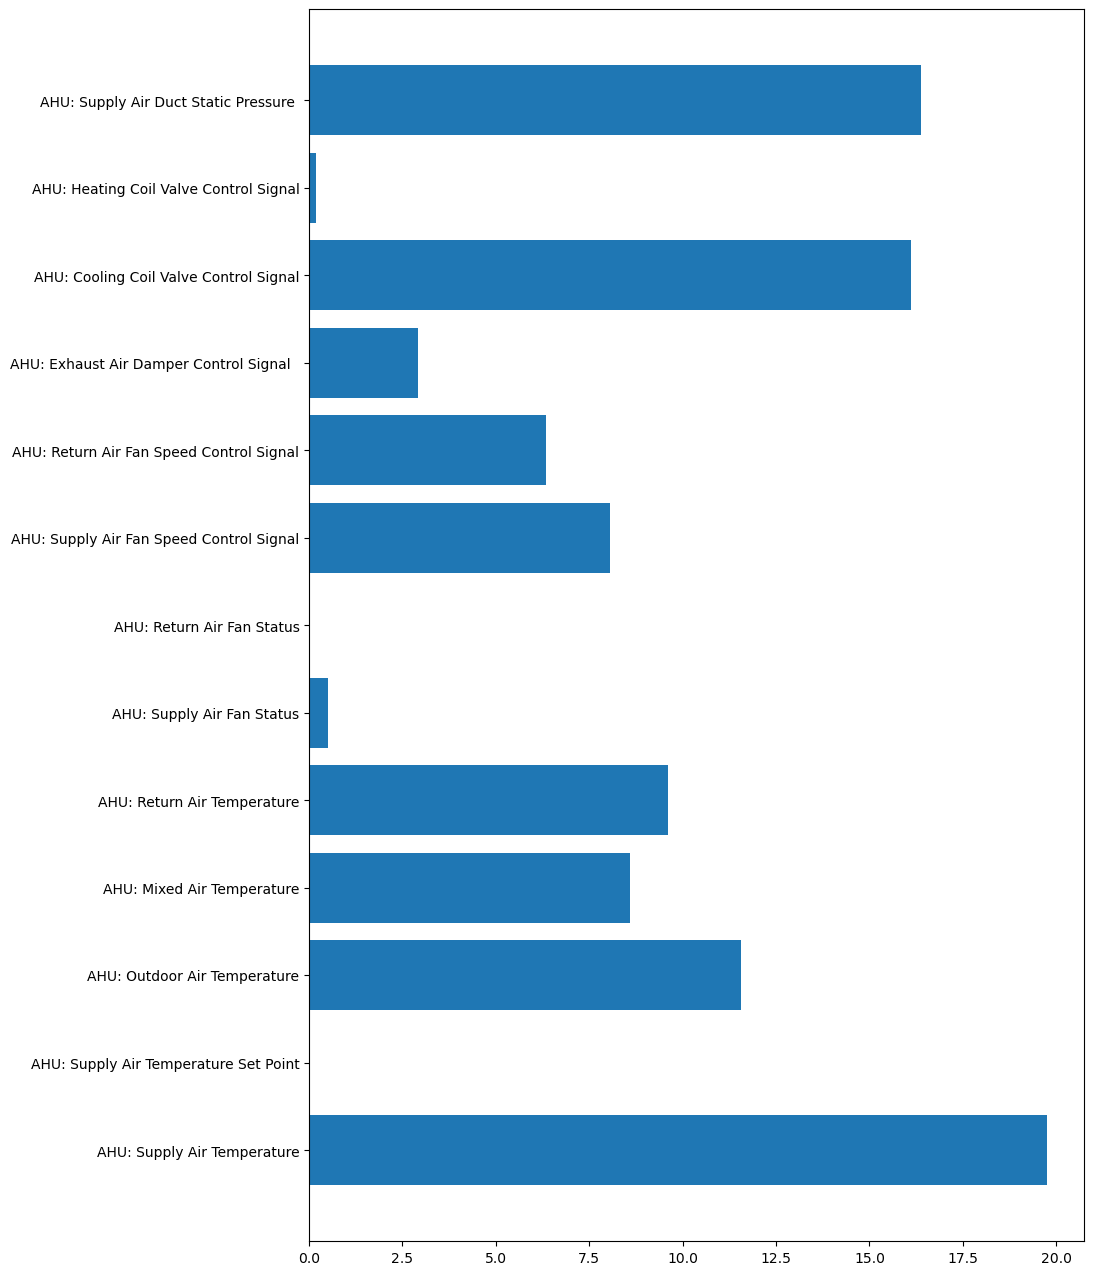

In [52]:
plt.figure(figsize=(10,16))
plt.barh(X_sim.columns, models_heat[4].get_feature_importance())

The weights above appear to align logically with the system's operational dynamics. Notably, differences exist between this model and the model constructed using experimental data. These differences could arise from distinct characteristics of the simulated and experimental datasets, reflecting the variability between these two sources of information.

# Simulation and experimental model comparison

Currently, we possess two categories of models originating from an alternate data source. Despite their distinct origins, these models share a common objective: detecting malfunctioning heating valve leaks within the similar systems. Consequently, it becomes viable to conduct a comparative analysis of these models' performance when applied to different datasets. This assessment will shed light on the models' versatility and adaptability across varied data contexts.

## Model trained on experimnetal data -  predict on an simulated data

In [53]:
Acc_exp_on_sim = pd.DataFrame(index=None, columns=['model','accuracy','precision','recall','f1'])

In [54]:
# Preparing feature data with columns from the experimental data model.
X_exp_on_sim = raw_data_sim[X_exp.columns]

In [55]:
for model in models_exp:
    name = str(model).split('Classifier')[0]
    y_pred = model.predict(X_exp_on_sim)
    acc = accuracy_score(y_heat, y_pred)
    prec = precision_score(y_heat, y_pred)    
    rec = recall_score(y_heat, y_pred)
    f1 = f1_score(y_heat, y_pred)
    
    Acc_exp_on_sim = Acc_exp_on_sim.append(pd.Series({'model':name,
                                'accuracy': acc,
                                'precision': prec,
                                'recall': rec,
                                'f1': f1}),ignore_index=True)

In [56]:
print(Acc_exp_on_sim)

                     model  accuracy  precision    recall        f1
0               KNeighbors  0.759455   0.276389  0.670370  0.391404
1                      MLP  0.571768   0.165285  0.669444  0.265114
2                 AdaBoost  0.552644   0.198281  0.945370  0.327808
3         GradientBoosting  0.567788   0.204042  0.946528  0.335714
4  <catboost.core.CatBoost  0.544044   0.191871  0.918981  0.317460
5                      XGB  0.603499   0.200875  0.818056  0.322548
6                  Bagging  0.565304   0.187091  0.827315  0.305170
7             RandomForest  0.575294   0.201751  0.906713  0.330061
8             DecisionTree  0.559989   0.180057  0.791667  0.293386
9     LogisticRegression()  0.612660   0.143986  0.476620  0.221160


The outcomes reveal a substantial decline in the predictive performance of all models, particularly in terms of precision. Notably, the models predicted a significantly higher number of faults compared to the actual occurrences. This trend is consistent across all models, suggesting that the decrease in performance isn't attributed to particular or poor model training. Rather, it is likely a result of the dissimilar dependencies present in the experimental data when compared to the simulated data.

To varify the consistency of this behavior, it is necessary to investigate whether this pattern persists in reverse scenario. 

## Model trained on simulated data - prediction on an experimental data

In [57]:
Acc_sim_on_exp = pd.DataFrame(index=None, columns=['model','accuracy','precision','recall','f1'])

In [58]:
# Preparing feature data with columns from the experimental data model.
X_sim_on_exp = raw_data_exp[X_sim.columns]

In [59]:
for model in models_heat:
    name = str(model).split('Classifier')[0]
    y_pred = model.predict(X_sim_on_exp)
    acc = accuracy_score(y_exp, y_pred)
    prec = precision_score(y_exp, y_pred)    
    rec = recall_score(y_exp, y_pred)
    f1 = f1_score(y_exp, y_pred)
    
    Acc_sim_on_exp = Acc_sim_on_exp.append(pd.Series({'model':name,
                                'accuracy': acc,
                                'precision': prec,
                                'recall': rec,
                                'f1': f1}),ignore_index=True)

In [60]:
print(Acc_sim_on_exp)

                     model  accuracy  precision    recall        f1
0               KNeighbors  0.856759   0.393426  0.137153  0.203399
1                      MLP  0.873287   0.657143  0.103819  0.179310
2                 AdaBoost  0.867176   0.600000  0.011458  0.022487
3         GradientBoosting  0.867269   0.584416  0.015625  0.030436
4  <catboost.core.CatBoost  0.866898   0.539683  0.011806  0.023106
5                      XGB  0.866389   0.470588  0.016667  0.032193
6                  Bagging  0.857731   0.181518  0.019097  0.034559
7             RandomForest  0.867315   0.850000  0.005903  0.011724
8             DecisionTree  0.838565   0.248966  0.104514  0.147224
9     LogisticRegression()  0.867593   1.000000  0.006944  0.013793


In this instance, the models' performance further deteriorated, reaffirming the previous assumptions that the relationships present in real-world data differ from those within the simulated data. This confirmation underscores the significance of data source variability and its impact on the models' ability to generalize effectively.

# Final conclusions

In summation, the outcomes emphasize the viability of employing machine learning models for fault detection within a system. Nevertheless, the choice of data source significantly influences model performance. When utilizing well-constructed data, the majority of models exhibit outstanding performance even without extensive model tuning or data balancing.

Regrettably, the limitation emerges that simulation data might not be suitable for model training. While generating data through simulation offers cost-effective benefits, the resulting model's efficacy is inherently constrained by the accuracy of the simulation model. This essentially creates a scenario where a model is based on another model, presenting limitations for real-world practicality. The ultimate requirement is to develop a model that closely mirrors reality, maximizing its usefulness in real-world applications.